## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()


ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#gray.shape[::-1] returns image height and width like 960, 1280. can also be img.shape[0:2]
#dist:distortion coeff, mtx:camera matrix 3D-2D, rvecs-tvecs: rotation and translation vectors from world to image

dst=cv2.undistort(img, mtx, dist, None, mtx)

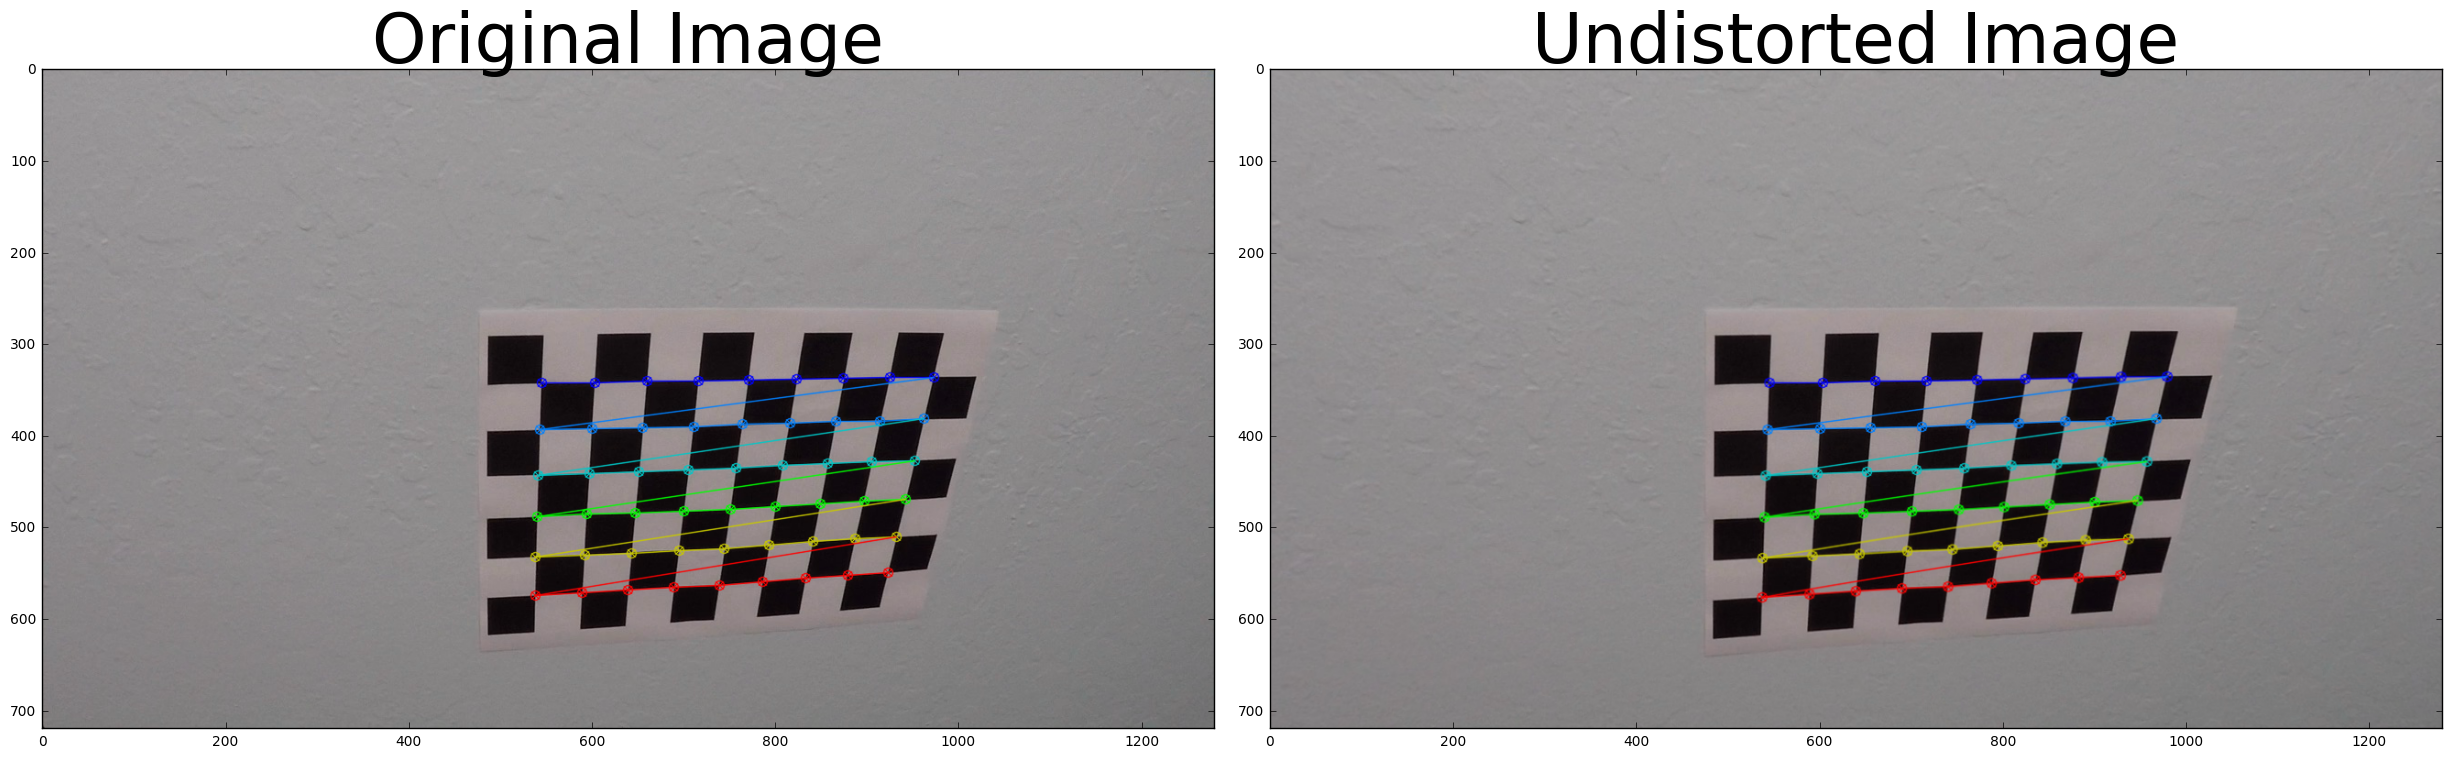

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## And so on and so forth...

In [170]:
image_raw = mpimg.imread('../test_images/hard2.jpg')
image=cv2.undistort(image_raw, mtx, dist, None, mtx)


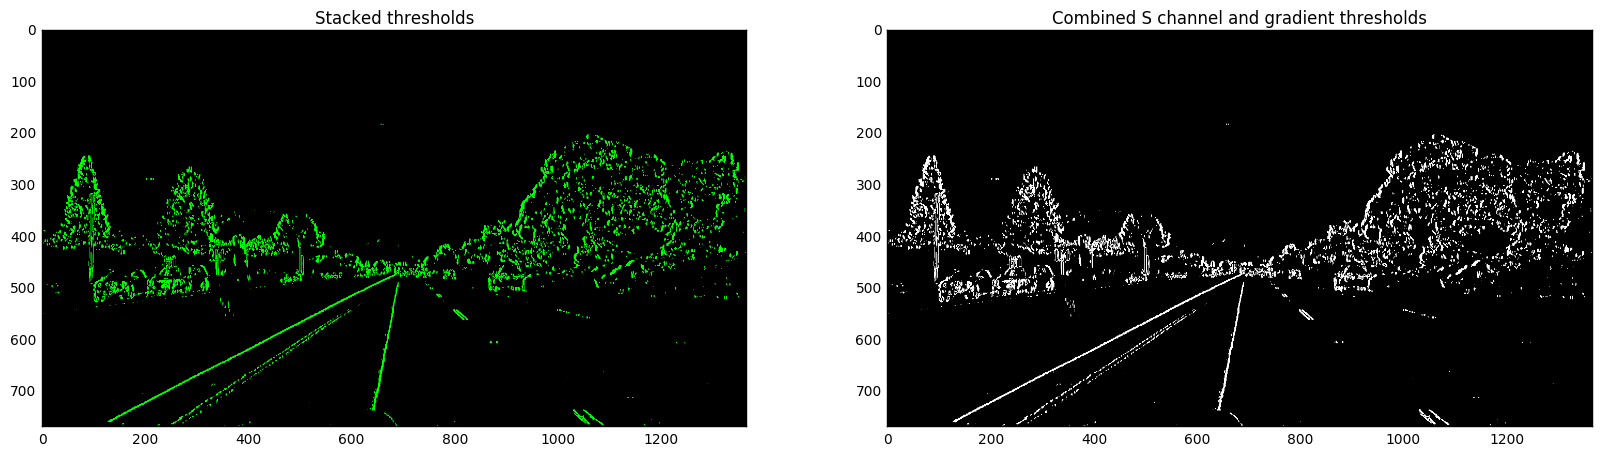

In [171]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
img=np.copy(image)


hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
#green is sxbinary, blue is s_binary
color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
#ax1.imshow(s_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [172]:


def warp(img):
    global N, Ninv
    img_size=(img.shape[1], image.shape[0])
    #Four source coordinates
    #src=np.float32(
    #    [[img.shape[1]/2-50, img.shape[0]/2+90],
    #    [img.shape[1]/2+100, img.shape[0]/2+90],
    #    [img.shape[1]/2+540, img.shape[0]],
    #    [img.shape[1]/2-450, img.shape[0]]])
    #vertices = np.array([[(img.shape[1]/2-300, img.shape[0]-240),
    #    (img.shape[1]/2+300, img.shape[0]-240),
    #    (img.shape[1]/2+500, img.shape[0]),
    #    (img.shape[1]/2-500, img.shape[0])]], dtype=np.int32)
    
    src=np.float32(
        [[img.shape[1]/2-120, img.shape[0]-230],
        [img.shape[1]/2+120, img.shape[0]-230],
        [img.shape[1]/2+650, img.shape[0]],
        [img.shape[1]/2-650, img.shape[0]]])
    

    #Four destination coordinates
    dst=np.float32([
        [img.shape[1]*2/6, 0],
        [img.shape[1]*4/6, 0],
        [img.shape[1]*4/6, img.shape[0]],
        [img.shape[1]*2/6, img.shape[0]]])

    N=cv2.getPerspectiveTransform(src, dst)

    Ninv=cv2.getPerspectiveTransform(dst, src)

    warped=cv2.warpPerspective(img, N, img_size, flags=cv2.INTER_LINEAR)
    
    vertices = np.array([[(img.shape[1]/2-270, 0),
        (img.shape[1]/2+270, 0),
        (img.shape[1]/2+270, img.shape[0]),
        (img.shape[1]/2-270, img.shape[0])]], dtype=np.int32)
    
    masked=region_of_interest(warped, vertices)
    
    return masked

In [173]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

(768, 1366, 3)


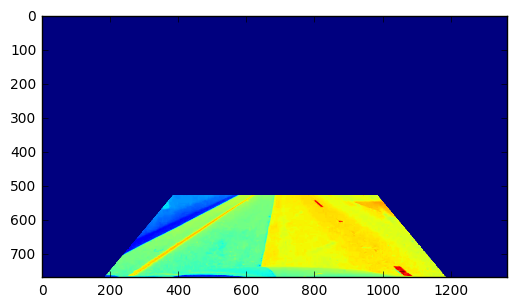

In [174]:
warped_img=warp(combined_binary)
warped=np.copy(warped_img)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
imshape = image.shape
print(imshape)
vertices = np.array([[(img.shape[1]/2-300, img.shape[0]-240),
        (img.shape[1]/2+300, img.shape[0]-240),
        (img.shape[1]/2+500, img.shape[0]),
        (img.shape[1]/2-500, img.shape[0])]], dtype=np.int32)
    
masked_img=region_of_interest(gray, vertices)
plt.imshow(masked_img)

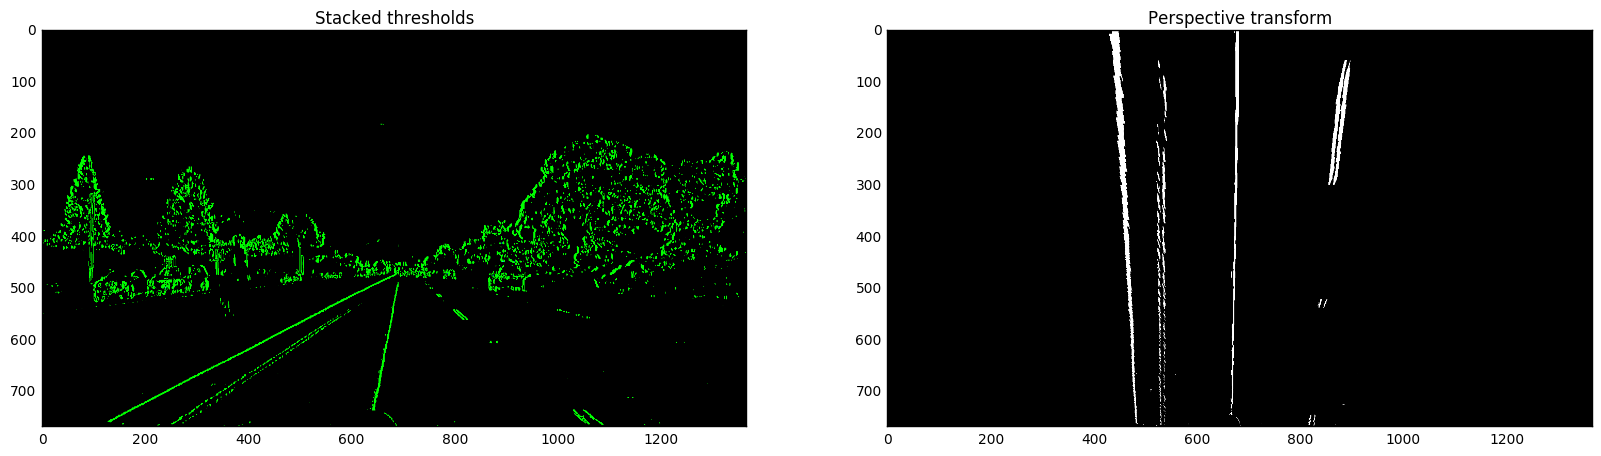

In [175]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Perspective transform')
ax2.imshow(warped_img, cmap='gray')

(768, 1366)


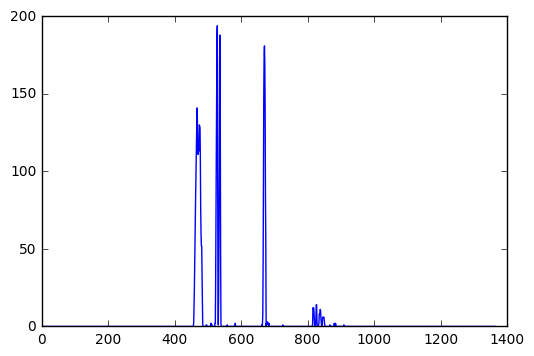

In [176]:
binary_warped=np.copy(warped_img)
print(binary_warped.shape)
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [177]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint]) #get the peak from first half(left)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint #get peak from secondhalf(right)

# Choose the number of sliding windows
nwindows = 9 
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
print(nonzeroy.shape)
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 75
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(16923,)


(768, 0)

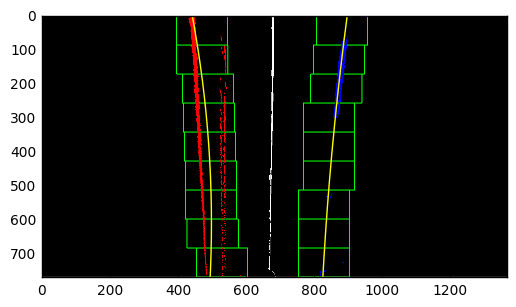

In [178]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)

In [179]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(768, 0)

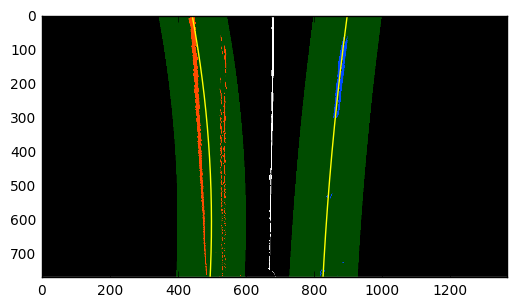

In [180]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0], 0)

In [181]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/img.shape[0] # meters per pixel in y dimension
xm_per_pix = 3.7/img.shape[1] # meters per pixel in x dimension
# Fit a second order polynomial to each

y_eval = np.max(ploty)

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


1852.77443219 m 5449.4832298 m


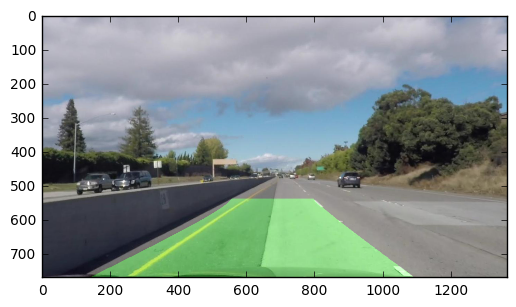

In [182]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Ninv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)

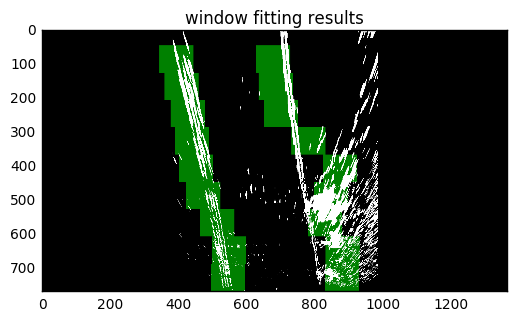

In [65]:
# Read in a thresholded image
warped = np.copy(warped_img)*255
# window settings
window_width = 100 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0)) #constrain for x, cannot less than 0 or more than shape[1]
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [151]:
def pipeline(img):

    image=cv2.undistort(img, mtx, dist, None, mtx)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 200
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #green is sxbinary, blue is s_binary
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary*255, s_binary*255))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1


    img_size=(image.shape[1], image.shape[0])
    #Four source coordinates
    #src=np.float32(
    #    [[img.shape[1]/2-50, img.shape[0]/2+90],
    #    [img.shape[1]/2+100, img.shape[0]/2+90],
    #    [img.shape[1]/2+540, img.shape[0]],
    #    [img.shape[1]/2-450, img.shape[0]]])
    src=np.float32(
        [[image.shape[1]/2-120, image.shape[0]-230],
        [image.shape[1]/2+120, image.shape[0]-230],
        [image.shape[1]/2+650, image.shape[0]],
        [image.shape[1]/2-650, image.shape[0]]])
    

    #Four destination coordinates
    dst=np.float32([
        [image.shape[1]*2/6, 0],
        [image.shape[1]*4/6, 0],
        [image.shape[1]*4/6, image.shape[0]],
        [image.shape[1]*2/6, image.shape[0]]])

    N=cv2.getPerspectiveTransform(src, dst)

    Ninv=cv2.getPerspectiveTransform(dst, src)

    warped=cv2.warpPerspective(combined_binary, N, img_size, flags=cv2.INTER_LINEAR)

    vertices = np.array([[(image.shape[1]/2-270, 0),
        (image.shape[1]/2+270, 0),
        (image.shape[1]/2+270, image.shape[0]),
        (image.shape[1]/2-270, image.shape[0])]], dtype=np.int32)
    
    warped_img=region_of_interest(warped, vertices)

    warped=np.copy(warped_img)
    
    binary_warped=np.copy(warped_img)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) #get the peak from first half(left)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #get peak from secondhalf(right)

    # Choose the number of sliding windows
    nwindows = 9 
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/image.shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/image.shape[1] # meters per pixel in x dimension
    # Fit a second order polynomial to each

    y_eval = np.max(ploty)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp=cv2.addWeighted(color_warp, 0.8, out_img, 1., 0.)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Ninv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 0.8, newwarp, 1, 0)    

    
    radius=(left_curverad+right_curverad)/2
    
    text="Radius of curvature %f" %radius
    result=cv2.putText(result, text, (100, 100), cv2.FONT_HERSHEY_PLAIN,  3, 255)
    #return color_binary
    return result

255


/home/rm/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


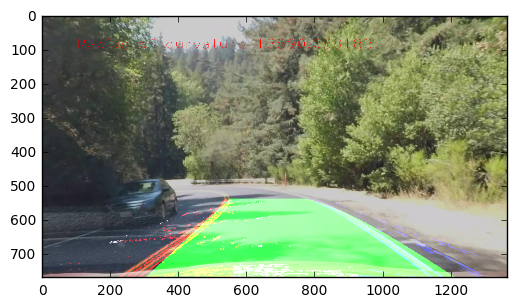

In [161]:
image_raw = mpimg.imread('../test_images/hard11.jpg')
image=cv2.undistort(image_raw, mtx, dist, None, mtx)

plt.imshow(pipeline(image))

In [164]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
project_output = '../project_video_result.mp4'
clip1 = VideoFileClip("../project_video.mp4")
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video ../project_video_result.mp4
[MoviePy] Writing video ../project_video_result.mp4


100%|█████████▉| 1260/1261 [03:53<00:00,  5.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_result.mp4 

CPU times: user 5min 57s, sys: 2.94 s, total: 6min
Wall time: 3min 54s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [165]:
project_output = '../challenge_video_result.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

255
[MoviePy] >>>> Building video ../challenge_video_result.mp4
[MoviePy] Writing video ../challenge_video_result.mp4


  0%|          | 1/485 [00:00<01:17,  6.28it/s]

255
255


  1%|          | 3/485 [00:00<01:56,  4.14it/s]

255
255


  1%|          | 5/485 [00:01<01:34,  5.06it/s]

255
255


  1%|▏         | 7/485 [00:01<01:24,  5.66it/s]

255
255


  2%|▏         | 10/485 [00:01<01:14,  6.39it/s]

255
255


  2%|▏         | 11/485 [00:02<01:58,  4.00it/s]

255
255


  3%|▎         | 14/485 [00:02<01:24,  5.55it/s]

255
255


  3%|▎         | 15/485 [00:02<01:22,  5.73it/s]

255
255


  4%|▎         | 18/485 [00:03<01:14,  6.30it/s]

255
255


  4%|▍         | 19/485 [00:03<01:12,  6.43it/s]

255
255


  4%|▍         | 21/485 [00:03<01:12,  6.36it/s]

255
255


  5%|▍         | 23/485 [00:04<01:12,  6.41it/s]

255
255


  5%|▌         | 25/485 [00:04<01:10,  6.51it/s]

255
255


  6%|▌         | 28/485 [00:04<01:08,  6.65it/s]

255
255


  6%|▌         | 29/485 [00:05<01:08,  6.62it/s]

255
255


  7%|▋         | 32/485 [00:05<01:07,  6.75it/s]

255
255


  7%|▋         | 34/485 [00:05<01:06,  6.77it/s]

255
255


  7%|▋         | 36/485 [00:06<01:06,  6.76it/s]

255
255


  8%|▊         | 38/485 [00:06<01:05,  6.81it/s]

255
255


  8%|▊         | 40/485 [00:06<01:04,  6.85it/s]

255
255


  8%|▊         | 41/485 [00:06<01:06,  6.72it/s]

255
255


  9%|▉         | 43/485 [00:07<01:10,  6.29it/s]

255
255


  9%|▉         | 45/485 [00:07<01:15,  5.81it/s]

255
255


 10%|▉         | 47/485 [00:07<01:13,  5.94it/s]

255
255


 10%|█         | 49/485 [00:08<01:14,  5.88it/s]

255
255


 11%|█         | 51/485 [00:08<01:13,  5.89it/s]

255
255


 11%|█         | 53/485 [00:08<01:13,  5.91it/s]

255
255


 11%|█▏        | 55/485 [00:09<01:12,  5.95it/s]

255
255


 12%|█▏        | 57/485 [00:09<01:11,  6.01it/s]

255
255


 12%|█▏        | 59/485 [00:09<01:13,  5.82it/s]

255
255


 13%|█▎        | 61/485 [00:10<01:12,  5.88it/s]

255
255


 13%|█▎        | 63/485 [00:10<01:11,  5.88it/s]

255
255


 13%|█▎        | 65/485 [00:10<01:10,  5.97it/s]

255
255


 14%|█▍        | 67/485 [00:11<01:11,  5.84it/s]

255
255


 14%|█▍        | 69/485 [00:11<01:08,  6.08it/s]

255
255


 15%|█▍        | 71/485 [00:11<01:08,  6.05it/s]

255
255


 15%|█▌        | 73/485 [00:12<01:07,  6.10it/s]

255
255


 15%|█▌        | 75/485 [00:12<01:08,  6.00it/s]

255
255


 16%|█▌        | 77/485 [00:12<01:08,  5.93it/s]

255
255


 16%|█▋        | 79/485 [00:13<01:09,  5.83it/s]

255
255


 17%|█▋        | 81/485 [00:13<01:08,  5.86it/s]

255
255


 17%|█▋        | 83/485 [00:14<01:09,  5.81it/s]

255
255


 18%|█▊        | 85/485 [00:14<01:07,  5.94it/s]

255
255


 18%|█▊        | 87/485 [00:14<01:06,  5.97it/s]

255
255


 18%|█▊        | 89/485 [00:14<01:05,  6.09it/s]

255
255


 19%|█▉        | 91/485 [00:15<01:05,  6.04it/s]

255
255


 19%|█▉        | 93/485 [00:15<01:08,  5.76it/s]

255
255


 20%|█▉        | 95/485 [00:16<01:07,  5.82it/s]

255
255


 20%|██        | 97/485 [00:16<01:06,  5.88it/s]

255
255


 20%|██        | 99/485 [00:16<01:05,  5.86it/s]

255
255


 21%|██        | 101/485 [00:17<01:04,  5.91it/s]

255
255


 21%|██        | 103/485 [00:17<01:04,  5.96it/s]

255
255


 22%|██▏       | 105/485 [00:17<01:02,  6.08it/s]

255
255


 22%|██▏       | 107/485 [00:18<01:04,  5.89it/s]

255
255


 22%|██▏       | 109/485 [00:18<01:03,  5.96it/s]

255
255


 23%|██▎       | 111/485 [00:18<01:03,  5.93it/s]

255
255


 23%|██▎       | 113/485 [00:19<01:05,  5.72it/s]

255
255


 24%|██▎       | 115/485 [00:19<01:05,  5.69it/s]

255
255


 24%|██▍       | 117/485 [00:19<01:04,  5.71it/s]

255
255


 25%|██▍       | 119/485 [00:20<01:04,  5.67it/s]

255
255


 25%|██▍       | 121/485 [00:20<01:02,  5.78it/s]

255
255


 25%|██▌       | 123/485 [00:20<00:59,  6.07it/s]

255
255


 26%|██▌       | 125/485 [00:21<00:58,  6.13it/s]

255
255


 26%|██▌       | 127/485 [00:21<00:56,  6.31it/s]

255
255


 27%|██▋       | 129/485 [00:21<00:58,  6.08it/s]

255
255


 27%|██▋       | 131/485 [00:22<00:59,  5.93it/s]

255
255


 27%|██▋       | 133/485 [00:22<00:58,  5.97it/s]

255
255


 28%|██▊       | 135/485 [00:22<00:58,  5.94it/s]

255
255


 28%|██▊       | 137/485 [00:23<00:57,  6.01it/s]

255
255


 29%|██▊       | 139/485 [00:23<00:58,  5.96it/s]

255
255


 29%|██▉       | 141/485 [00:23<00:55,  6.17it/s]

255
255


 29%|██▉       | 143/485 [00:24<00:56,  6.10it/s]

255
255


 30%|███       | 146/485 [00:24<00:53,  6.31it/s]

255
255


 30%|███       | 147/485 [00:24<00:57,  5.83it/s]

255


 31%|███       | 148/485 [00:24<00:59,  5.70it/s]

255
255


 31%|███       | 150/485 [00:25<00:56,  5.95it/s]

255
255


 31%|███▏      | 152/485 [00:25<01:00,  5.48it/s]

255
255


 32%|███▏      | 154/485 [00:26<00:57,  5.73it/s]

255
255


 32%|███▏      | 156/485 [00:26<01:02,  5.29it/s]

255


 32%|███▏      | 157/485 [00:26<01:03,  5.14it/s]

255
255


 33%|███▎      | 159/485 [00:26<01:00,  5.43it/s]

255
255


 33%|███▎      | 161/485 [00:27<00:57,  5.59it/s]

255
255


 34%|███▎      | 163/485 [00:27<00:59,  5.42it/s]

255
255


 34%|███▍      | 165/485 [00:28<00:56,  5.71it/s]

255
255


 34%|███▍      | 167/485 [00:28<00:56,  5.62it/s]

255
255


 35%|███▍      | 169/485 [00:28<00:56,  5.55it/s]

255
255


 35%|███▌      | 171/485 [00:29<00:56,  5.59it/s]

255
255


 36%|███▌      | 173/485 [00:29<00:56,  5.55it/s]

255
255


 36%|███▌      | 175/485 [00:29<00:55,  5.58it/s]

255
255


 36%|███▋      | 177/485 [00:30<00:54,  5.70it/s]

255
255


 37%|███▋      | 179/485 [00:30<00:57,  5.28it/s]

255
255


 37%|███▋      | 181/485 [00:30<00:55,  5.46it/s]

255
255


 38%|███▊      | 183/485 [00:31<00:57,  5.26it/s]

255
255


 38%|███▊      | 185/485 [00:31<00:54,  5.52it/s]

255
255


 39%|███▊      | 187/485 [00:32<00:55,  5.37it/s]

255
255


 39%|███▉      | 189/485 [00:32<00:55,  5.37it/s]

255
255


 39%|███▉      | 191/485 [00:32<00:53,  5.51it/s]

255
255


 40%|███▉      | 193/485 [00:33<00:52,  5.56it/s]

255
255


 40%|████      | 195/485 [00:33<00:50,  5.71it/s]

255
255


 41%|████      | 197/485 [00:33<00:50,  5.76it/s]

255
255


 41%|████      | 199/485 [00:34<00:50,  5.72it/s]

255
255


 41%|████▏     | 201/485 [00:34<00:50,  5.66it/s]

255
255


 42%|████▏     | 203/485 [00:34<00:48,  5.83it/s]

255
255


 42%|████▏     | 205/485 [00:35<00:48,  5.79it/s]

255
255


 43%|████▎     | 207/485 [00:35<00:48,  5.77it/s]

255
255


 43%|████▎     | 209/485 [00:35<00:48,  5.64it/s]

255
255


 44%|████▎     | 211/485 [00:36<00:48,  5.67it/s]

255
255


 44%|████▍     | 213/485 [00:36<00:47,  5.74it/s]

255
255


 44%|████▍     | 215/485 [00:36<00:46,  5.79it/s]

255
255


 45%|████▍     | 217/485 [00:37<00:45,  5.92it/s]

255
255


 45%|████▌     | 219/485 [00:37<00:46,  5.75it/s]

255
255


 46%|████▌     | 221/485 [00:38<00:46,  5.66it/s]

255
255


 46%|████▌     | 223/485 [00:38<00:46,  5.62it/s]

255
255


 46%|████▋     | 225/485 [00:38<00:47,  5.52it/s]

255
255


 47%|████▋     | 227/485 [00:39<00:45,  5.67it/s]

255
255


 47%|████▋     | 229/485 [00:39<00:44,  5.76it/s]

255
255


 48%|████▊     | 231/485 [00:39<00:47,  5.40it/s]

255
255


 48%|████▊     | 233/485 [00:40<00:44,  5.66it/s]

255
255


 48%|████▊     | 235/485 [00:40<00:45,  5.49it/s]

255
255


 49%|████▉     | 237/485 [00:40<00:44,  5.58it/s]

255
255


 49%|████▉     | 239/485 [00:41<00:43,  5.67it/s]

255
255


 50%|████▉     | 241/485 [00:41<00:43,  5.67it/s]

255
255


 50%|█████     | 243/485 [00:41<00:44,  5.49it/s]

255
255


 51%|█████     | 245/485 [00:42<00:42,  5.68it/s]

255
255


 51%|█████     | 247/485 [00:42<00:41,  5.78it/s]

255
255


 51%|█████▏    | 249/485 [00:43<00:40,  5.78it/s]

255
255


 52%|█████▏    | 251/485 [00:43<00:40,  5.73it/s]

255
255


 52%|█████▏    | 253/485 [00:43<00:39,  5.82it/s]

255
255


 53%|█████▎    | 255/485 [00:44<00:40,  5.66it/s]

255
255


 53%|█████▎    | 257/485 [00:44<00:40,  5.63it/s]

255
255


 53%|█████▎    | 259/485 [00:44<00:40,  5.64it/s]

255
255


 54%|█████▍    | 261/485 [00:45<00:39,  5.71it/s]

255
255


 54%|█████▍    | 263/485 [00:45<00:38,  5.75it/s]

255
255


 55%|█████▍    | 265/485 [00:45<00:38,  5.74it/s]

255
255


 55%|█████▌    | 267/485 [00:46<00:38,  5.65it/s]

255
255


 55%|█████▌    | 269/485 [00:46<00:38,  5.58it/s]

255
255


 56%|█████▌    | 271/485 [00:46<00:37,  5.76it/s]

255
255


 56%|█████▋    | 273/485 [00:47<00:37,  5.66it/s]

255
255


 57%|█████▋    | 275/485 [00:47<00:36,  5.69it/s]

255
255


 57%|█████▋    | 277/485 [00:47<00:37,  5.57it/s]

255
255


 58%|█████▊    | 279/485 [00:48<00:36,  5.67it/s]

255
255


 58%|█████▊    | 281/485 [00:48<00:36,  5.58it/s]

255
255


 58%|█████▊    | 283/485 [00:48<00:36,  5.51it/s]

255
255


 59%|█████▉    | 285/485 [00:49<00:35,  5.59it/s]

255
255


 59%|█████▉    | 287/485 [00:49<00:36,  5.46it/s]

255
255


 60%|█████▉    | 289/485 [00:50<00:34,  5.62it/s]

255
255


 60%|██████    | 291/485 [00:50<00:33,  5.71it/s]

255
255


 60%|██████    | 293/485 [00:50<00:34,  5.49it/s]

255
255


 61%|██████    | 295/485 [00:51<00:34,  5.58it/s]

255
255


 61%|██████    | 297/485 [00:51<00:32,  5.74it/s]

255
255


 62%|██████▏   | 299/485 [00:51<00:31,  5.86it/s]

255
255


 62%|██████▏   | 301/485 [00:52<00:31,  5.91it/s]

255
255


 62%|██████▏   | 303/485 [00:52<00:31,  5.84it/s]

255
255


 63%|██████▎   | 305/485 [00:52<00:31,  5.67it/s]

255
255


 63%|██████▎   | 307/485 [00:53<00:31,  5.73it/s]

255


 64%|██████▎   | 308/485 [00:53<00:32,  5.51it/s]

255
255


 64%|██████▍   | 310/485 [00:53<00:33,  5.17it/s]

255


 64%|██████▍   | 311/485 [00:53<00:35,  4.97it/s]

255


 64%|██████▍   | 312/485 [00:54<00:35,  4.89it/s]

255
255


 65%|██████▍   | 314/485 [00:54<00:33,  5.03it/s]

255
255


 65%|██████▌   | 316/485 [00:54<00:31,  5.37it/s]

255
255


 66%|██████▌   | 318/485 [00:55<00:31,  5.34it/s]

255


 66%|██████▌   | 319/485 [00:55<00:31,  5.26it/s]

255
255


 66%|██████▌   | 321/485 [00:55<00:31,  5.27it/s]

255
255


 67%|██████▋   | 323/485 [00:56<00:31,  5.15it/s]

255
255


 67%|██████▋   | 325/485 [00:56<00:30,  5.23it/s]

255
255


 67%|██████▋   | 327/485 [00:57<00:30,  5.24it/s]

255
255


 68%|██████▊   | 329/485 [00:57<00:29,  5.22it/s]

255


 68%|██████▊   | 330/485 [00:57<00:30,  5.13it/s]

255
255


 68%|██████▊   | 332/485 [00:58<00:30,  5.08it/s]

255
255


 69%|██████▉   | 334/485 [00:58<00:29,  5.12it/s]

255
255


 69%|██████▉   | 336/485 [00:58<00:27,  5.33it/s]

255
255


 70%|██████▉   | 338/485 [00:59<00:27,  5.28it/s]

255


 70%|██████▉   | 339/485 [00:59<00:27,  5.30it/s]

255
255


 70%|███████   | 341/485 [00:59<00:27,  5.15it/s]

255
255


 71%|███████   | 343/485 [01:00<00:26,  5.33it/s]

255
255


 71%|███████   | 345/485 [01:00<00:25,  5.43it/s]

255
255


 72%|███████▏  | 347/485 [01:00<00:26,  5.26it/s]

255
255


 72%|███████▏  | 349/485 [01:01<00:26,  5.21it/s]

255
255


 72%|███████▏  | 351/485 [01:01<00:25,  5.34it/s]

255
255


 73%|███████▎  | 353/485 [01:01<00:24,  5.36it/s]

255


 73%|███████▎  | 354/485 [01:02<00:24,  5.26it/s]

255
255


 73%|███████▎  | 356/485 [01:02<00:24,  5.36it/s]

255
255


 74%|███████▍  | 358/485 [01:02<00:25,  5.03it/s]

255
255


 74%|███████▍  | 360/485 [01:03<00:23,  5.23it/s]

255
255


 75%|███████▍  | 362/485 [01:03<00:23,  5.29it/s]

255
255


 75%|███████▌  | 364/485 [01:04<00:23,  5.15it/s]

255


 75%|███████▌  | 365/485 [01:04<00:23,  5.00it/s]

255


 75%|███████▌  | 366/485 [01:04<00:23,  5.02it/s]

255
255


 76%|███████▌  | 368/485 [01:04<00:22,  5.30it/s]

255
255


 76%|███████▋  | 370/485 [01:05<00:22,  5.11it/s]

255


 76%|███████▋  | 371/485 [01:05<00:22,  4.97it/s]

255
255


 77%|███████▋  | 373/485 [01:05<00:21,  5.20it/s]

255
255


 77%|███████▋  | 375/485 [01:06<00:20,  5.33it/s]

255
255


 78%|███████▊  | 377/485 [01:06<00:20,  5.35it/s]

255
255


 78%|███████▊  | 379/485 [01:06<00:19,  5.40it/s]

255
255


 79%|███████▊  | 381/485 [01:07<00:19,  5.47it/s]

255
255


 79%|███████▉  | 383/485 [01:07<00:19,  5.37it/s]

255
255


 79%|███████▉  | 385/485 [01:08<00:18,  5.38it/s]

255
255


 80%|███████▉  | 387/485 [01:08<00:17,  5.48it/s]

255


 80%|████████  | 388/485 [01:08<00:18,  5.29it/s]

255


 80%|████████  | 389/485 [01:08<00:18,  5.19it/s]

255
255


 81%|████████  | 391/485 [01:09<00:18,  5.19it/s]

255


 81%|████████  | 392/485 [01:09<00:18,  5.09it/s]

255
255


 81%|████████  | 394/485 [01:09<00:17,  5.17it/s]

255
255


 82%|████████▏ | 396/485 [01:10<00:16,  5.36it/s]

255
255


 82%|████████▏ | 398/485 [01:10<00:15,  5.55it/s]

255
255


 82%|████████▏ | 400/485 [01:10<00:16,  5.26it/s]

255


 83%|████████▎ | 401/485 [01:11<00:16,  5.17it/s]

255
255


 83%|████████▎ | 403/485 [01:11<00:16,  5.11it/s]

255
255


 84%|████████▎ | 405/485 [01:11<00:15,  5.07it/s]

255
255


 84%|████████▍ | 407/485 [01:12<00:14,  5.43it/s]

255
255


 84%|████████▍ | 409/485 [01:12<00:13,  5.70it/s]

255
255


 85%|████████▍ | 411/485 [01:12<00:14,  5.09it/s]

255


 85%|████████▍ | 412/485 [01:13<00:14,  4.99it/s]

255


 85%|████████▌ | 413/485 [01:13<00:15,  4.65it/s]

255


 85%|████████▌ | 414/485 [01:13<00:15,  4.68it/s]

255


 86%|████████▌ | 415/485 [01:13<00:14,  4.80it/s]

255
255


 86%|████████▌ | 417/485 [01:14<00:13,  4.86it/s]

255
255


 86%|████████▋ | 419/485 [01:14<00:13,  4.89it/s]

255


 87%|████████▋ | 420/485 [01:14<00:13,  4.71it/s]

255


 87%|████████▋ | 421/485 [01:15<00:13,  4.89it/s]

255
255


 87%|████████▋ | 423/485 [01:15<00:12,  4.83it/s]

255


 87%|████████▋ | 424/485 [01:15<00:12,  4.79it/s]

255
255


 88%|████████▊ | 426/485 [01:16<00:11,  4.97it/s]

255
255


 88%|████████▊ | 428/485 [01:16<00:11,  5.14it/s]

255
255


 89%|████████▊ | 430/485 [01:16<00:10,  5.09it/s]

255
255


 89%|████████▉ | 432/485 [01:17<00:10,  5.16it/s]

255
255


 89%|████████▉ | 434/485 [01:17<00:09,  5.35it/s]

255
255


 90%|████████▉ | 436/485 [01:17<00:08,  5.50it/s]

255
255


 90%|█████████ | 438/485 [01:18<00:08,  5.41it/s]

255
255


 91%|█████████ | 440/485 [01:18<00:08,  5.01it/s]

255
255


 91%|█████████ | 442/485 [01:19<00:08,  5.15it/s]

255
255


 92%|█████████▏| 444/485 [01:19<00:07,  5.32it/s]

255


 92%|█████████▏| 445/485 [01:19<00:07,  5.36it/s]

255
255


 92%|█████████▏| 447/485 [01:20<00:07,  5.35it/s]

255
255


 93%|█████████▎| 449/485 [01:20<00:06,  5.23it/s]

255
255


 93%|█████████▎| 451/485 [01:20<00:06,  5.44it/s]

255
255


 93%|█████████▎| 453/485 [01:21<00:05,  5.39it/s]

255
255


 94%|█████████▍| 455/485 [01:21<00:05,  5.47it/s]

255


 94%|█████████▍| 456/485 [01:21<00:05,  5.28it/s]

255
255

 94%|█████████▍| 457/485 [01:21<00:05,  5.22it/s]

 94%|█████████▍| 458/485 [01:22<00:05,  5.13it/s]

255
255

 95%|█████████▍| 460/485 [01:22<00:04,  5.20it/s]


255
255


 95%|█████████▌| 462/485 [01:22<00:04,  5.43it/s]

255
255


 96%|█████████▌| 464/485 [01:23<00:03,  5.36it/s]

255
255


 96%|█████████▌| 466/485 [01:23<00:03,  5.57it/s]

255
255


 96%|█████████▋| 468/485 [01:24<00:03,  5.47it/s]

255
255


 97%|█████████▋| 470/485 [01:24<00:02,  5.34it/s]

255
255


 97%|█████████▋| 472/485 [01:24<00:02,  5.38it/s]

255
255


 98%|█████████▊| 474/485 [01:25<00:02,  5.35it/s]

255
255


 98%|█████████▊| 476/485 [01:25<00:01,  5.66it/s]

255
255

 98%|█████████▊| 477/485 [01:25<00:01,  5.48it/s]


255


 99%|█████████▉| 479/485 [01:26<00:01,  5.43it/s]

255
255


 99%|█████████▉| 481/485 [01:26<00:00,  5.33it/s]

255
255


100%|█████████▉| 483/485 [01:26<00:00,  5.38it/s]

255
255


100%|██████████| 485/485 [01:27<00:00,  5.28it/s]

255


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_video_result.mp4 

CPU times: user 2min 10s, sys: 1.78 s, total: 2min 12s
Wall time: 1min 29s


In [166]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [167]:
project_output = '../harder_video_result.mp4'
clip1 = VideoFileClip("../harder_challenge_video.mp4")
project_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

255
[MoviePy] >>>> Building video ../harder_video_result.mp4
[MoviePy] Writing video ../harder_video_result.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

255


  0%|          | 2/1200 [00:00<05:10,  3.86it/s]

255


  0%|          | 3/1200 [00:00<05:11,  3.84it/s]

255


  0%|          | 4/1200 [00:01<05:02,  3.95it/s]

255


  0%|          | 5/1200 [00:01<04:49,  4.13it/s]

255
255


  1%|          | 7/1200 [00:01<04:27,  4.47it/s]

255
255


  1%|          | 9/1200 [00:02<03:58,  5.00it/s]

255
255


  1%|          | 11/1200 [00:02<03:47,  5.24it/s]

255
255


  1%|          | 13/1200 [00:02<03:35,  5.50it/s]

255
255


  1%|▏         | 15/1200 [00:03<03:29,  5.66it/s]

255
255


  1%|▏         | 17/1200 [00:03<03:22,  5.84it/s]

255
255


  2%|▏         | 19/1200 [00:03<03:21,  5.87it/s]

255
255


  2%|▏         | 21/1200 [00:04<03:18,  5.93it/s]

255
255


  2%|▏         | 23/1200 [00:04<03:15,  6.03it/s]

255
255


  2%|▏         | 25/1200 [00:04<03:15,  6.01it/s]

255
255


  2%|▏         | 27/1200 [00:05<03:13,  6.06it/s]

255
255


  2%|▏         | 29/1200 [00:05<03:17,  5.94it/s]

255
255


  3%|▎         | 31/1200 [00:05<03:15,  5.97it/s]

255
255


  3%|▎         | 33/1200 [00:06<03:16,  5.93it/s]

255
255


  3%|▎         | 35/1200 [00:06<03:17,  5.89it/s]

255
255


  3%|▎         | 37/1200 [00:06<03:19,  5.82it/s]

255
255


  3%|▎         | 39/1200 [00:07<03:17,  5.88it/s]

255
255


  3%|▎         | 41/1200 [00:07<03:18,  5.82it/s]

255
255


  4%|▎         | 43/1200 [00:07<03:29,  5.52it/s]

255
255


  4%|▍         | 45/1200 [00:08<03:37,  5.32it/s]

255
255


  4%|▍         | 47/1200 [00:08<03:33,  5.41it/s]

255
255


  4%|▍         | 49/1200 [00:09<04:00,  4.79it/s]

255


  4%|▍         | 50/1200 [00:09<04:12,  4.56it/s]

255


  4%|▍         | 51/1200 [00:09<04:18,  4.44it/s]

255
255

  4%|▍         | 53/1200 [00:09<03:59,  4.80it/s]


255


  4%|▍         | 54/1200 [00:10<03:55,  4.87it/s]

255


  5%|▍         | 55/1200 [00:10<04:01,  4.74it/s]

255


  5%|▍         | 56/1200 [00:10<04:02,  4.72it/s]

255
255


  5%|▍         | 58/1200 [00:10<03:54,  4.87it/s]

255
255

  5%|▍         | 59/1200 [00:11<03:59,  4.77it/s]

  5%|▌         | 60/1200 [00:11<03:57,  4.81it/s]

255


  5%|▌         | 61/1200 [00:11<04:07,  4.59it/s]

255


  5%|▌         | 62/1200 [00:11<04:01,  4.72it/s]

255


  5%|▌         | 63/1200 [00:12<03:58,  4.77it/s]

255


  5%|▌         | 64/1200 [00:12<04:00,  4.73it/s]

255
255


  6%|▌         | 66/1200 [00:12<03:52,  4.87it/s]

255
255

  6%|▌         | 67/1200 [00:12<03:52,  4.87it/s]

  6%|▌         | 68/1200 [00:13<03:56,  4.79it/s]

255


  6%|▌         | 69/1200 [00:13<03:55,  4.80it/s]

255


  6%|▌         | 70/1200 [00:13<03:57,  4.77it/s]

255


  6%|▌         | 71/1200 [00:13<04:03,  4.64it/s]

255


  6%|▌         | 72/1200 [00:13<04:01,  4.67it/s]

255


  6%|▌         | 73/1200 [00:14<04:04,  4.61it/s]

255


  6%|▌         | 74/1200 [00:14<03:58,  4.72it/s]

255


  6%|▋         | 75/1200 [00:14<03:58,  4.71it/s]

255
255


  6%|▋         | 77/1200 [00:14<03:48,  4.91it/s]

255
255


  7%|▋         | 79/1200 [00:15<03:35,  5.20it/s]

255


  7%|▋         | 80/1200 [00:15<03:52,  4.82it/s]

255


  7%|▋         | 81/1200 [00:15<04:01,  4.63it/s]

255
255


  7%|▋         | 83/1200 [00:16<03:54,  4.76it/s]

255


  7%|▋         | 84/1200 [00:16<04:11,  4.44it/s]

255


  7%|▋         | 85/1200 [00:16<04:05,  4.54it/s]

255


  7%|▋         | 86/1200 [00:16<04:07,  4.50it/s]

255


  7%|▋         | 87/1200 [00:17<04:16,  4.34it/s]

255


  7%|▋         | 88/1200 [00:17<04:18,  4.30it/s]

255


  7%|▋         | 89/1200 [00:17<04:11,  4.42it/s]

255


  8%|▊         | 90/1200 [00:17<04:16,  4.32it/s]

255


  8%|▊         | 91/1200 [00:18<04:21,  4.25it/s]

255


  8%|▊         | 92/1200 [00:18<04:19,  4.27it/s]

255


  8%|▊         | 93/1200 [00:18<04:31,  4.08it/s]

255


  8%|▊         | 94/1200 [00:18<04:23,  4.20it/s]

255


  8%|▊         | 95/1200 [00:19<04:22,  4.20it/s]

255


  8%|▊         | 96/1200 [00:19<04:25,  4.16it/s]

255


  8%|▊         | 97/1200 [00:19<04:11,  4.38it/s]

255


  8%|▊         | 98/1200 [00:19<04:10,  4.41it/s]

255
255


  8%|▊         | 100/1200 [00:20<03:38,  5.03it/s]

255
255


  8%|▊         | 102/1200 [00:20<03:32,  5.17it/s]

255
255


  9%|▊         | 104/1200 [00:20<03:21,  5.44it/s]

255
255

  9%|▉         | 106/1200 [00:21<03:43,  4.90it/s]


255


  9%|▉         | 107/1200 [00:21<03:46,  4.82it/s]

255


  9%|▉         | 108/1200 [00:21<03:58,  4.58it/s]

255


  9%|▉         | 109/1200 [00:21<04:01,  4.52it/s]

255


  9%|▉         | 110/1200 [00:22<04:06,  4.43it/s]

255


  9%|▉         | 111/1200 [00:22<04:09,  4.37it/s]

255


  9%|▉         | 112/1200 [00:22<04:06,  4.41it/s]

255


  9%|▉         | 113/1200 [00:22<04:07,  4.39it/s]

255


 10%|▉         | 114/1200 [00:23<03:57,  4.57it/s]

255
255


 10%|▉         | 116/1200 [00:23<03:54,  4.62it/s]

255


 10%|▉         | 117/1200 [00:23<03:58,  4.55it/s]

255


 10%|▉         | 118/1200 [00:23<04:04,  4.42it/s]

255


 10%|▉         | 119/1200 [00:24<04:14,  4.25it/s]

255


 10%|█         | 120/1200 [00:24<04:11,  4.30it/s]

255


 10%|█         | 121/1200 [00:24<04:13,  4.26it/s]

255


 10%|█         | 122/1200 [00:24<04:18,  4.16it/s]

255


 10%|█         | 123/1200 [00:25<04:19,  4.14it/s]

255


 10%|█         | 124/1200 [00:25<04:11,  4.28it/s]

255
255


 10%|█         | 126/1200 [00:25<03:55,  4.57it/s]

255
255


 11%|█         | 128/1200 [00:26<03:54,  4.57it/s]

255


 11%|█         | 129/1200 [00:26<03:48,  4.69it/s]

255


 11%|█         | 130/1200 [00:26<04:03,  4.40it/s]

255


 11%|█         | 131/1200 [00:26<04:05,  4.36it/s]

255


 11%|█         | 132/1200 [00:27<03:57,  4.50it/s]

255


 11%|█         | 133/1200 [00:27<03:49,  4.65it/s]

255
255


 11%|█▏        | 135/1200 [00:27<03:52,  4.57it/s]

255


 11%|█▏        | 136/1200 [00:27<04:00,  4.42it/s]

255


 11%|█▏        | 137/1200 [00:28<04:15,  4.16it/s]

255


 12%|█▏        | 138/1200 [00:28<04:18,  4.10it/s]

255


 12%|█▏        | 139/1200 [00:28<04:22,  4.04it/s]

255


 12%|█▏        | 140/1200 [00:29<04:19,  4.09it/s]

255


 12%|█▏        | 141/1200 [00:29<04:14,  4.16it/s]

255


 12%|█▏        | 142/1200 [00:29<04:21,  4.04it/s]

255


 12%|█▏        | 143/1200 [00:29<04:22,  4.03it/s]

255


 12%|█▏        | 144/1200 [00:29<04:18,  4.09it/s]

255


 12%|█▏        | 145/1200 [00:30<04:16,  4.11it/s]

255


 12%|█▏        | 146/1200 [00:30<04:14,  4.13it/s]

255


 12%|█▏        | 147/1200 [00:30<04:12,  4.17it/s]

255


 12%|█▏        | 148/1200 [00:30<04:06,  4.27it/s]

255


 12%|█▏        | 149/1200 [00:31<04:02,  4.34it/s]

255


 12%|█▎        | 150/1200 [00:31<04:00,  4.37it/s]

255


 13%|█▎        | 151/1200 [00:31<04:07,  4.24it/s]

255


 13%|█▎        | 152/1200 [00:31<04:22,  4.00it/s]

255


 13%|█▎        | 153/1200 [00:32<04:17,  4.06it/s]

255


 13%|█▎        | 154/1200 [00:32<04:13,  4.13it/s]

255


 13%|█▎        | 155/1200 [00:32<04:12,  4.14it/s]

255


 13%|█▎        | 156/1200 [00:32<04:14,  4.11it/s]

255


 13%|█▎        | 157/1200 [00:33<04:09,  4.18it/s]

255


 13%|█▎        | 158/1200 [00:33<04:09,  4.17it/s]

255


 13%|█▎        | 159/1200 [00:33<04:08,  4.18it/s]

255


 13%|█▎        | 160/1200 [00:33<04:12,  4.13it/s]

255


 13%|█▎        | 161/1200 [00:34<04:10,  4.14it/s]

255


 14%|█▎        | 162/1200 [00:34<04:06,  4.21it/s]

255


 14%|█▎        | 163/1200 [00:34<04:07,  4.18it/s]

255


 14%|█▎        | 164/1200 [00:34<04:14,  4.07it/s]

255
255


 14%|█▍        | 166/1200 [00:35<04:00,  4.31it/s]

255


 14%|█▍        | 167/1200 [00:35<04:04,  4.23it/s]

255


 14%|█▍        | 168/1200 [00:35<04:09,  4.14it/s]

255


 14%|█▍        | 169/1200 [00:35<04:05,  4.20it/s]

255


 14%|█▍        | 170/1200 [00:36<04:05,  4.19it/s]

255


 14%|█▍        | 171/1200 [00:36<04:10,  4.11it/s]

255


 14%|█▍        | 172/1200 [00:36<04:03,  4.22it/s]

255


 14%|█▍        | 173/1200 [00:36<04:02,  4.23it/s]

255


 14%|█▍        | 174/1200 [00:37<04:01,  4.24it/s]

255


 15%|█▍        | 175/1200 [00:37<04:10,  4.09it/s]

255


 15%|█▍        | 176/1200 [00:37<04:12,  4.05it/s]

255


 15%|█▍        | 177/1200 [00:37<04:17,  3.97it/s]

255


 15%|█▍        | 178/1200 [00:38<04:11,  4.06it/s]

255


 15%|█▍        | 179/1200 [00:38<04:12,  4.04it/s]

255


 15%|█▌        | 180/1200 [00:38<04:12,  4.04it/s]

255


 15%|█▌        | 181/1200 [00:38<04:11,  4.05it/s]

255


 15%|█▌        | 182/1200 [00:39<04:10,  4.06it/s]

255


 15%|█▌        | 183/1200 [00:39<04:12,  4.03it/s]

255


 15%|█▌        | 184/1200 [00:39<04:13,  4.01it/s]

255


 15%|█▌        | 185/1200 [00:39<04:13,  4.00it/s]

255


 16%|█▌        | 186/1200 [00:40<04:07,  4.10it/s]

255


 16%|█▌        | 187/1200 [00:40<03:56,  4.29it/s]

255


 16%|█▌        | 188/1200 [00:40<04:05,  4.12it/s]

255


 16%|█▌        | 189/1200 [00:40<04:04,  4.13it/s]

255


 16%|█▌        | 190/1200 [00:41<04:06,  4.09it/s]

255


 16%|█▌        | 191/1200 [00:41<04:13,  3.99it/s]

255


 16%|█▌        | 192/1200 [00:41<04:09,  4.04it/s]

255


 16%|█▌        | 193/1200 [00:41<04:15,  3.95it/s]

255


 16%|█▌        | 194/1200 [00:42<04:13,  3.97it/s]

255


 16%|█▋        | 195/1200 [00:42<04:11,  3.99it/s]

255


 16%|█▋        | 196/1200 [00:42<04:09,  4.02it/s]

255


 16%|█▋        | 197/1200 [00:42<04:13,  3.96it/s]

255


 16%|█▋        | 198/1200 [00:43<04:08,  4.03it/s]

255


 17%|█▋        | 199/1200 [00:43<04:12,  3.96it/s]

255


 17%|█▋        | 200/1200 [00:43<04:10,  3.99it/s]

255
255


 17%|█▋        | 202/1200 [00:44<03:48,  4.36it/s]

255


 17%|█▋        | 203/1200 [00:44<03:43,  4.46it/s]

255


 17%|█▋        | 204/1200 [00:44<03:42,  4.48it/s]

255


 17%|█▋        | 205/1200 [00:44<03:34,  4.63it/s]

255
255


 17%|█▋        | 207/1200 [00:45<03:26,  4.81it/s]

255
255


 17%|█▋        | 209/1200 [00:45<03:18,  4.99it/s]

255
255


 18%|█▊        | 211/1200 [00:45<03:35,  4.59it/s]

255


 18%|█▊        | 212/1200 [00:46<03:50,  4.29it/s]

255


 18%|█▊        | 213/1200 [00:46<03:48,  4.32it/s]

255


 18%|█▊        | 214/1200 [00:46<03:51,  4.27it/s]

255


 18%|█▊        | 215/1200 [00:46<03:49,  4.30it/s]

255


 18%|█▊        | 216/1200 [00:47<03:53,  4.21it/s]

255


 18%|█▊        | 217/1200 [00:47<03:51,  4.24it/s]

255


 18%|█▊        | 218/1200 [00:47<03:48,  4.30it/s]

255


 18%|█▊        | 219/1200 [00:47<03:44,  4.37it/s]

255


 18%|█▊        | 220/1200 [00:48<03:53,  4.21it/s]

255


 18%|█▊        | 221/1200 [00:48<03:48,  4.28it/s]

255


 18%|█▊        | 222/1200 [00:48<04:04,  4.00it/s]

255


 19%|█▊        | 223/1200 [00:48<04:07,  3.96it/s]

255


 19%|█▊        | 224/1200 [00:49<04:09,  3.91it/s]

255


 19%|█▉        | 225/1200 [00:49<04:12,  3.87it/s]

255


 19%|█▉        | 226/1200 [00:49<04:13,  3.84it/s]

255


 19%|█▉        | 227/1200 [00:49<03:58,  4.08it/s]

255


 19%|█▉        | 228/1200 [00:50<03:54,  4.14it/s]

255


 19%|█▉        | 229/1200 [00:50<03:54,  4.15it/s]

255


 19%|█▉        | 230/1200 [00:50<03:52,  4.18it/s]

255


 19%|█▉        | 231/1200 [00:50<03:48,  4.25it/s]

255


 19%|█▉        | 232/1200 [00:51<03:53,  4.14it/s]

255


 19%|█▉        | 233/1200 [00:51<03:57,  4.07it/s]

255


 20%|█▉        | 234/1200 [00:51<04:01,  4.00it/s]

255


 20%|█▉        | 235/1200 [00:51<04:03,  3.96it/s]

255


 20%|█▉        | 236/1200 [00:52<04:09,  3.86it/s]

255


 20%|█▉        | 237/1200 [00:52<04:08,  3.87it/s]

255


 20%|█▉        | 238/1200 [00:52<04:11,  3.83it/s]

255


 20%|█▉        | 239/1200 [00:52<04:21,  3.67it/s]

255


 20%|██        | 240/1200 [00:53<04:22,  3.66it/s]

255


 20%|██        | 241/1200 [00:53<04:06,  3.89it/s]

255


 20%|██        | 242/1200 [00:53<04:25,  3.60it/s]

255


 20%|██        | 243/1200 [00:54<04:28,  3.57it/s]

255


 20%|██        | 244/1200 [00:54<04:18,  3.70it/s]

255


 20%|██        | 245/1200 [00:54<04:19,  3.67it/s]

255


 20%|██        | 246/1200 [00:54<04:17,  3.70it/s]

255


 21%|██        | 247/1200 [00:55<04:17,  3.70it/s]

255


 21%|██        | 248/1200 [00:55<04:10,  3.80it/s]

255


 21%|██        | 249/1200 [00:55<04:15,  3.73it/s]

255


 21%|██        | 250/1200 [00:55<03:59,  3.96it/s]

255


 21%|██        | 251/1200 [00:56<03:51,  4.09it/s]

255


 21%|██        | 252/1200 [00:56<03:53,  4.06it/s]

255


 21%|██        | 253/1200 [00:56<03:50,  4.11it/s]

255


 21%|██        | 254/1200 [00:56<03:47,  4.17it/s]

255


 21%|██▏       | 255/1200 [00:56<03:48,  4.13it/s]

255


 21%|██▏       | 256/1200 [00:57<03:42,  4.24it/s]

255


 21%|██▏       | 257/1200 [00:57<03:52,  4.06it/s]

255


 22%|██▏       | 258/1200 [00:57<03:55,  3.99it/s]

255


 22%|██▏       | 259/1200 [00:57<03:51,  4.07it/s]

255


 22%|██▏       | 260/1200 [00:58<03:46,  4.16it/s]

255


 22%|██▏       | 261/1200 [00:58<03:43,  4.20it/s]

255


 22%|██▏       | 262/1200 [00:58<03:44,  4.18it/s]

255


 22%|██▏       | 263/1200 [00:58<03:42,  4.22it/s]

255


 22%|██▏       | 264/1200 [00:59<03:49,  4.07it/s]

255


 22%|██▏       | 265/1200 [00:59<03:51,  4.04it/s]

255


 22%|██▏       | 266/1200 [00:59<03:40,  4.24it/s]

255


 22%|██▏       | 267/1200 [00:59<03:42,  4.19it/s]

255


 22%|██▏       | 268/1200 [01:00<03:50,  4.05it/s]

255


 22%|██▏       | 269/1200 [01:00<03:42,  4.18it/s]

255


 22%|██▎       | 270/1200 [01:00<03:42,  4.18it/s]

255


 23%|██▎       | 271/1200 [01:00<03:38,  4.24it/s]

255


 23%|██▎       | 272/1200 [01:01<03:44,  4.14it/s]

255


 23%|██▎       | 273/1200 [01:01<03:41,  4.19it/s]

255


 23%|██▎       | 274/1200 [01:01<03:35,  4.30it/s]

255


 23%|██▎       | 275/1200 [01:01<03:33,  4.34it/s]

255


 23%|██▎       | 276/1200 [01:02<03:35,  4.29it/s]

255


 23%|██▎       | 277/1200 [01:02<03:35,  4.29it/s]

255


 23%|██▎       | 278/1200 [01:02<03:43,  4.12it/s]

255


 23%|██▎       | 279/1200 [01:02<03:36,  4.24it/s]

255


 23%|██▎       | 280/1200 [01:03<03:48,  4.03it/s]

255


 23%|██▎       | 281/1200 [01:03<03:49,  4.01it/s]

255


 24%|██▎       | 282/1200 [01:03<03:45,  4.07it/s]

255


 24%|██▎       | 283/1200 [01:03<03:54,  3.91it/s]

255


 24%|██▎       | 284/1200 [01:04<03:55,  3.90it/s]

255


 24%|██▍       | 285/1200 [01:04<03:43,  4.10it/s]

255


 24%|██▍       | 286/1200 [01:04<03:42,  4.10it/s]

255


 24%|██▍       | 287/1200 [01:04<03:31,  4.32it/s]

255


 24%|██▍       | 288/1200 [01:04<03:35,  4.24it/s]

255


 24%|██▍       | 289/1200 [01:05<03:35,  4.22it/s]

255


 24%|██▍       | 290/1200 [01:05<03:33,  4.26it/s]

255


 24%|██▍       | 291/1200 [01:05<03:28,  4.36it/s]

255


 24%|██▍       | 292/1200 [01:05<03:24,  4.44it/s]

255


 24%|██▍       | 293/1200 [01:06<03:22,  4.47it/s]

255
255


 25%|██▍       | 295/1200 [01:06<03:22,  4.47it/s]

255


 25%|██▍       | 296/1200 [01:06<03:25,  4.40it/s]

255


 25%|██▍       | 297/1200 [01:06<03:18,  4.55it/s]

255
255


 25%|██▍       | 299/1200 [01:07<03:11,  4.71it/s]

255


 25%|██▌       | 300/1200 [01:07<03:14,  4.64it/s]

255
255

 25%|██▌       | 301/1200 [01:07<03:11,  4.68it/s]

 25%|██▌       | 302/1200 [01:07<03:11,  4.68it/s]

255
255


 25%|██▌       | 304/1200 [01:08<03:03,  4.87it/s]

255
255


 26%|██▌       | 306/1200 [01:08<03:02,  4.90it/s]

255


 26%|██▌       | 307/1200 [01:09<03:04,  4.84it/s]

255
255


 26%|██▌       | 309/1200 [01:09<03:03,  4.85it/s]

255


 26%|██▌       | 310/1200 [01:09<03:05,  4.80it/s]

255


 26%|██▌       | 311/1200 [01:09<03:04,  4.83it/s]

255
255


 26%|██▌       | 313/1200 [01:10<03:01,  4.88it/s]

255


 26%|██▌       | 314/1200 [01:10<03:07,  4.72it/s]

255


 26%|██▋       | 315/1200 [01:10<03:05,  4.76it/s]

255


 26%|██▋       | 316/1200 [01:10<03:04,  4.79it/s]

255
255


 26%|██▋       | 318/1200 [01:11<03:01,  4.85it/s]

255
255


 27%|██▋       | 320/1200 [01:11<02:59,  4.89it/s]

255
255


 27%|██▋       | 322/1200 [01:12<02:55,  5.01it/s]

255
255


 27%|██▋       | 324/1200 [01:12<03:00,  4.86it/s]

255


 27%|██▋       | 325/1200 [01:12<02:59,  4.88it/s]

255


 27%|██▋       | 326/1200 [01:12<03:03,  4.77it/s]

255


 27%|██▋       | 327/1200 [01:13<03:02,  4.78it/s]

255


 27%|██▋       | 328/1200 [01:13<03:01,  4.80it/s]

255
255


 28%|██▊       | 330/1200 [01:13<02:54,  4.97it/s]

255
255


 28%|██▊       | 332/1200 [01:14<02:52,  5.05it/s]

255
255


 28%|██▊       | 334/1200 [01:14<02:52,  5.03it/s]

255
255


 28%|██▊       | 336/1200 [01:14<02:54,  4.95it/s]

255


 28%|██▊       | 337/1200 [01:15<02:59,  4.81it/s]

255


 28%|██▊       | 338/1200 [01:15<02:59,  4.81it/s]

255


 28%|██▊       | 339/1200 [01:15<03:04,  4.68it/s]

255


 28%|██▊       | 340/1200 [01:15<03:12,  4.47it/s]

255


 28%|██▊       | 341/1200 [01:16<03:02,  4.71it/s]

255
255

 29%|██▊       | 343/1200 [01:16<03:01,  4.73it/s]


255


 29%|██▊       | 344/1200 [01:16<03:05,  4.62it/s]

255


 29%|██▉       | 345/1200 [01:16<03:09,  4.51it/s]

255


 29%|██▉       | 346/1200 [01:17<03:12,  4.45it/s]

255


 29%|██▉       | 347/1200 [01:17<03:09,  4.51it/s]

255


 29%|██▉       | 348/1200 [01:17<03:12,  4.43it/s]

255


 29%|██▉       | 349/1200 [01:17<03:19,  4.27it/s]

255


 29%|██▉       | 350/1200 [01:18<03:26,  4.12it/s]

255


 29%|██▉       | 351/1200 [01:18<03:19,  4.25it/s]

255


 29%|██▉       | 352/1200 [01:18<03:15,  4.33it/s]

255


 29%|██▉       | 353/1200 [01:18<03:09,  4.47it/s]

255


 30%|██▉       | 354/1200 [01:18<03:12,  4.38it/s]

255


 30%|██▉       | 355/1200 [01:19<03:09,  4.46it/s]

255


 30%|██▉       | 356/1200 [01:19<03:01,  4.65it/s]

255
255


 30%|██▉       | 358/1200 [01:19<02:59,  4.70it/s]

255
255


 30%|███       | 360/1200 [01:20<02:52,  4.87it/s]

255


 30%|███       | 361/1200 [01:20<02:56,  4.77it/s]

255
255


 30%|███       | 363/1200 [01:20<02:49,  4.93it/s]

255


 30%|███       | 364/1200 [01:21<02:55,  4.76it/s]

255


 30%|███       | 365/1200 [01:21<02:55,  4.76it/s]

255


 30%|███       | 366/1200 [01:21<03:05,  4.50it/s]

255


 31%|███       | 367/1200 [01:21<03:07,  4.45it/s]

255


 31%|███       | 368/1200 [01:21<03:12,  4.32it/s]

255


 31%|███       | 369/1200 [01:22<03:13,  4.29it/s]

255


 31%|███       | 370/1200 [01:22<03:10,  4.35it/s]

255


 31%|███       | 371/1200 [01:22<03:08,  4.40it/s]

255


 31%|███       | 372/1200 [01:22<03:05,  4.47it/s]

255


 31%|███       | 373/1200 [01:23<03:13,  4.27it/s]

255


 31%|███       | 374/1200 [01:23<03:12,  4.28it/s]

255


 31%|███▏      | 375/1200 [01:23<03:07,  4.40it/s]

255


 31%|███▏      | 376/1200 [01:23<03:14,  4.25it/s]

255


 31%|███▏      | 377/1200 [01:24<03:12,  4.28it/s]

255


 32%|███▏      | 378/1200 [01:24<03:13,  4.26it/s]

255


 32%|███▏      | 379/1200 [01:24<03:09,  4.34it/s]

255


 32%|███▏      | 380/1200 [01:24<03:04,  4.44it/s]

255


 32%|███▏      | 381/1200 [01:24<02:59,  4.55it/s]

255


 32%|███▏      | 382/1200 [01:25<03:01,  4.52it/s]

255


 32%|███▏      | 383/1200 [01:25<02:56,  4.64it/s]

255


 32%|███▏      | 384/1200 [01:25<02:59,  4.55it/s]

255


 32%|███▏      | 385/1200 [01:25<03:01,  4.49it/s]

255


 32%|███▏      | 386/1200 [01:26<03:02,  4.46it/s]

255


 32%|███▏      | 387/1200 [01:26<03:03,  4.43it/s]

255


 32%|███▏      | 388/1200 [01:26<03:04,  4.40it/s]

255
255


 32%|███▎      | 390/1200 [01:26<03:02,  4.45it/s]

255


 33%|███▎      | 391/1200 [01:27<03:04,  4.39it/s]

255


 33%|███▎      | 392/1200 [01:27<03:04,  4.37it/s]

255


 33%|███▎      | 393/1200 [01:27<03:00,  4.46it/s]

255


 33%|███▎      | 394/1200 [01:27<03:04,  4.37it/s]

255


 33%|███▎      | 395/1200 [01:28<03:06,  4.32it/s]

255


 33%|███▎      | 396/1200 [01:28<03:06,  4.30it/s]

255
255


 33%|███▎      | 398/1200 [01:28<03:03,  4.36it/s]

255


 33%|███▎      | 399/1200 [01:29<03:04,  4.34it/s]

255


 33%|███▎      | 400/1200 [01:29<03:02,  4.38it/s]

255


 33%|███▎      | 401/1200 [01:29<03:10,  4.18it/s]

255


 34%|███▎      | 402/1200 [01:29<03:07,  4.27it/s]

255


 34%|███▎      | 403/1200 [01:29<03:02,  4.36it/s]

255


 34%|███▎      | 404/1200 [01:30<03:03,  4.34it/s]

255


 34%|███▍      | 405/1200 [01:30<03:03,  4.33it/s]

255


 34%|███▍      | 406/1200 [01:30<03:01,  4.37it/s]

255


 34%|███▍      | 407/1200 [01:30<03:00,  4.39it/s]

255


 34%|███▍      | 408/1200 [01:31<03:08,  4.21it/s]

255


 34%|███▍      | 409/1200 [01:31<03:05,  4.26it/s]

255


 34%|███▍      | 410/1200 [01:31<03:11,  4.12it/s]

255


 34%|███▍      | 411/1200 [01:31<03:04,  4.27it/s]

255


 34%|███▍      | 412/1200 [01:32<03:12,  4.09it/s]

255


 34%|███▍      | 413/1200 [01:32<03:11,  4.12it/s]

255


 34%|███▍      | 414/1200 [01:32<03:09,  4.14it/s]

255


 35%|███▍      | 415/1200 [01:32<02:59,  4.36it/s]

255


 35%|███▍      | 416/1200 [01:33<03:04,  4.25it/s]

255


 35%|███▍      | 417/1200 [01:33<02:58,  4.39it/s]

255


 35%|███▍      | 418/1200 [01:33<03:04,  4.24it/s]

255


 35%|███▍      | 419/1200 [01:33<03:00,  4.33it/s]

255


 35%|███▌      | 420/1200 [01:33<03:01,  4.30it/s]

255


 35%|███▌      | 421/1200 [01:34<03:02,  4.26it/s]

255


 35%|███▌      | 422/1200 [01:34<03:00,  4.30it/s]

255


 35%|███▌      | 423/1200 [01:34<02:55,  4.43it/s]

255


 35%|███▌      | 424/1200 [01:34<03:03,  4.22it/s]

255


 35%|███▌      | 425/1200 [01:35<03:00,  4.29it/s]

255


 36%|███▌      | 426/1200 [01:35<03:00,  4.29it/s]

255


 36%|███▌      | 427/1200 [01:35<02:58,  4.33it/s]

255


 36%|███▌      | 428/1200 [01:35<02:52,  4.49it/s]

255


 36%|███▌      | 429/1200 [01:36<02:57,  4.35it/s]

255


 36%|███▌      | 430/1200 [01:36<02:58,  4.32it/s]

255


 36%|███▌      | 431/1200 [01:36<03:01,  4.23it/s]

255


 36%|███▌      | 432/1200 [01:36<03:02,  4.20it/s]

255


 36%|███▌      | 433/1200 [01:36<03:04,  4.16it/s]

255


 36%|███▌      | 434/1200 [01:37<03:02,  4.20it/s]

255


 36%|███▋      | 435/1200 [01:37<03:03,  4.18it/s]

255


 36%|███▋      | 436/1200 [01:37<02:59,  4.25it/s]

255


 36%|███▋      | 437/1200 [01:37<02:52,  4.42it/s]

255


 36%|███▋      | 438/1200 [01:38<02:59,  4.24it/s]

255


 37%|███▋      | 439/1200 [01:38<02:54,  4.36it/s]

255


 37%|███▋      | 440/1200 [01:38<02:48,  4.50it/s]

255


 37%|███▋      | 441/1200 [01:38<02:51,  4.43it/s]

255


 37%|███▋      | 442/1200 [01:39<02:51,  4.41it/s]

255


 37%|███▋      | 443/1200 [01:39<02:51,  4.40it/s]

255


 37%|███▋      | 444/1200 [01:39<02:50,  4.44it/s]

255


 37%|███▋      | 445/1200 [01:39<02:46,  4.52it/s]

255


 37%|███▋      | 446/1200 [01:39<02:46,  4.53it/s]

255


 37%|███▋      | 447/1200 [01:40<02:44,  4.57it/s]

255


 37%|███▋      | 448/1200 [01:40<02:49,  4.43it/s]

255


 37%|███▋      | 449/1200 [01:40<02:52,  4.36it/s]

255


 38%|███▊      | 450/1200 [01:40<02:50,  4.39it/s]

255


 38%|███▊      | 451/1200 [01:41<02:46,  4.49it/s]

255


 38%|███▊      | 452/1200 [01:41<02:44,  4.56it/s]

255


 38%|███▊      | 453/1200 [01:41<02:48,  4.44it/s]

255


 38%|███▊      | 454/1200 [01:41<02:49,  4.40it/s]

255


 38%|███▊      | 455/1200 [01:41<02:52,  4.33it/s]

255


 38%|███▊      | 456/1200 [01:42<02:51,  4.35it/s]

255


 38%|███▊      | 457/1200 [01:42<02:44,  4.51it/s]

255


 38%|███▊      | 458/1200 [01:42<02:45,  4.48it/s]

255


 38%|███▊      | 459/1200 [01:42<02:42,  4.55it/s]

255


 38%|███▊      | 460/1200 [01:43<02:52,  4.29it/s]

255


 38%|███▊      | 461/1200 [01:43<02:49,  4.36it/s]

255


 38%|███▊      | 462/1200 [01:43<02:50,  4.32it/s]

255


 39%|███▊      | 463/1200 [01:43<02:51,  4.30it/s]

255


 39%|███▊      | 464/1200 [01:44<02:52,  4.26it/s]

255


 39%|███▉      | 465/1200 [01:44<02:42,  4.53it/s]

255


 39%|███▉      | 466/1200 [01:44<02:44,  4.46it/s]

255
255


 39%|███▉      | 468/1200 [01:44<02:43,  4.49it/s]

255


 39%|███▉      | 469/1200 [01:45<02:46,  4.39it/s]

255


 39%|███▉      | 470/1200 [01:45<02:43,  4.46it/s]

255


 39%|███▉      | 471/1200 [01:45<02:38,  4.59it/s]

255


 39%|███▉      | 472/1200 [01:45<02:40,  4.54it/s]

255


 39%|███▉      | 473/1200 [01:45<02:33,  4.73it/s]

255


 40%|███▉      | 474/1200 [01:46<02:39,  4.54it/s]

255


 40%|███▉      | 475/1200 [01:46<02:39,  4.53it/s]

255


 40%|███▉      | 476/1200 [01:46<02:40,  4.51it/s]

255


 40%|███▉      | 477/1200 [01:46<02:42,  4.46it/s]

255


 40%|███▉      | 478/1200 [01:47<02:38,  4.57it/s]

255


 40%|███▉      | 479/1200 [01:47<02:41,  4.45it/s]

255


 40%|████      | 480/1200 [01:47<02:42,  4.42it/s]

255


 40%|████      | 481/1200 [01:47<02:44,  4.36it/s]

255


 40%|████      | 482/1200 [01:48<02:40,  4.48it/s]

255


 40%|████      | 483/1200 [01:48<02:42,  4.40it/s]

255


 40%|████      | 484/1200 [01:48<02:31,  4.72it/s]

255
255


 40%|████      | 486/1200 [01:48<02:26,  4.87it/s]

255


 41%|████      | 487/1200 [01:49<02:31,  4.72it/s]

255


 41%|████      | 488/1200 [01:49<02:36,  4.55it/s]

255


 41%|████      | 489/1200 [01:49<02:30,  4.72it/s]

255


 41%|████      | 490/1200 [01:49<02:31,  4.68it/s]

255
255


 41%|████      | 492/1200 [01:50<02:24,  4.91it/s]

255


 41%|████      | 493/1200 [01:50<02:29,  4.74it/s]

255


 41%|████      | 494/1200 [01:50<02:30,  4.68it/s]

255


 41%|████▏     | 495/1200 [01:50<02:30,  4.69it/s]

255


 41%|████▏     | 496/1200 [01:50<02:26,  4.80it/s]

255


 41%|████▏     | 497/1200 [01:51<02:28,  4.75it/s]

255


 42%|████▏     | 498/1200 [01:51<02:28,  4.73it/s]

255
255


 42%|████▏     | 500/1200 [01:51<02:25,  4.83it/s]

255


 42%|████▏     | 501/1200 [01:52<02:33,  4.56it/s]

255


 42%|████▏     | 502/1200 [01:52<02:25,  4.79it/s]

255


 42%|████▏     | 503/1200 [01:52<02:33,  4.53it/s]

255


 42%|████▏     | 504/1200 [01:52<02:26,  4.76it/s]

255


 42%|████▏     | 505/1200 [01:52<02:24,  4.81it/s]

255


 42%|████▏     | 506/1200 [01:53<02:32,  4.55it/s]

255


 42%|████▏     | 507/1200 [01:53<02:28,  4.65it/s]

255


 42%|████▏     | 508/1200 [01:53<02:27,  4.70it/s]

255


 42%|████▏     | 509/1200 [01:53<02:32,  4.52it/s]

255


 42%|████▎     | 510/1200 [01:53<02:32,  4.54it/s]

255


 43%|████▎     | 511/1200 [01:54<02:31,  4.54it/s]

255


 43%|████▎     | 512/1200 [01:54<02:31,  4.55it/s]

255


 43%|████▎     | 513/1200 [01:54<02:25,  4.73it/s]

255
255

 43%|████▎     | 514/1200 [01:54<02:27,  4.66it/s]

 43%|████▎     | 515/1200 [01:54<02:22,  4.80it/s]

255


 43%|████▎     | 516/1200 [01:55<02:26,  4.67it/s]

255


 43%|████▎     | 517/1200 [01:55<02:24,  4.74it/s]

255


 43%|████▎     | 518/1200 [01:55<02:26,  4.65it/s]

255


 43%|████▎     | 519/1200 [01:55<02:33,  4.44it/s]

255


 43%|████▎     | 520/1200 [01:56<02:31,  4.48it/s]

255


 43%|████▎     | 521/1200 [01:56<02:39,  4.24it/s]

255


 44%|████▎     | 522/1200 [01:56<02:33,  4.42it/s]

255


 44%|████▎     | 523/1200 [01:56<02:32,  4.43it/s]

255


 44%|████▎     | 524/1200 [01:57<02:38,  4.26it/s]

255


 44%|████▍     | 525/1200 [01:57<02:36,  4.32it/s]

255


 44%|████▍     | 526/1200 [01:57<02:33,  4.38it/s]

255


 44%|████▍     | 527/1200 [01:57<02:31,  4.43it/s]

255


 44%|████▍     | 528/1200 [01:57<02:33,  4.38it/s]

255


 44%|████▍     | 529/1200 [01:58<02:30,  4.46it/s]

255


 44%|████▍     | 530/1200 [01:58<02:31,  4.42it/s]

255


 44%|████▍     | 531/1200 [01:58<02:25,  4.59it/s]

255
255


 44%|████▍     | 533/1200 [01:59<02:21,  4.70it/s]

255


 44%|████▍     | 534/1200 [01:59<02:26,  4.54it/s]

255


 45%|████▍     | 535/1200 [01:59<02:28,  4.48it/s]

255


 45%|████▍     | 536/1200 [01:59<02:27,  4.49it/s]

255


 45%|████▍     | 537/1200 [01:59<02:29,  4.44it/s]

255


 45%|████▍     | 538/1200 [02:00<02:35,  4.27it/s]

255


 45%|████▍     | 539/1200 [02:00<02:33,  4.29it/s]

255


 45%|████▌     | 540/1200 [02:00<02:36,  4.22it/s]

255


 45%|████▌     | 541/1200 [02:00<02:35,  4.22it/s]

255


 45%|████▌     | 542/1200 [02:01<02:36,  4.22it/s]

255


 45%|████▌     | 543/1200 [02:01<02:34,  4.24it/s]

255


 45%|████▌     | 544/1200 [02:01<02:37,  4.16it/s]

255


 45%|████▌     | 545/1200 [02:01<02:35,  4.22it/s]

255


 46%|████▌     | 546/1200 [02:02<02:36,  4.19it/s]

255


 46%|████▌     | 547/1200 [02:02<02:35,  4.21it/s]

255


 46%|████▌     | 548/1200 [02:02<02:36,  4.15it/s]

255


 46%|████▌     | 549/1200 [02:02<02:30,  4.33it/s]

255


 46%|████▌     | 550/1200 [02:03<02:31,  4.30it/s]

255


 46%|████▌     | 551/1200 [02:03<02:24,  4.50it/s]

255
255


 46%|████▌     | 553/1200 [02:03<02:22,  4.55it/s]

255


 46%|████▌     | 554/1200 [02:03<02:17,  4.71it/s]

255


 46%|████▋     | 555/1200 [02:04<02:22,  4.53it/s]

255


 46%|████▋     | 556/1200 [02:04<02:23,  4.49it/s]

255


 46%|████▋     | 557/1200 [02:04<02:19,  4.60it/s]

255


 46%|████▋     | 558/1200 [02:04<02:22,  4.49it/s]

255


 47%|████▋     | 559/1200 [02:05<02:25,  4.42it/s]

255


 47%|████▋     | 560/1200 [02:05<02:23,  4.44it/s]

255


 47%|████▋     | 561/1200 [02:05<02:26,  4.35it/s]

255


 47%|████▋     | 562/1200 [02:05<02:25,  4.37it/s]

255


 47%|████▋     | 563/1200 [02:05<02:23,  4.44it/s]

255
255

 47%|████▋     | 564/1200 [02:06<02:20,  4.52it/s]

 47%|████▋     | 565/1200 [02:06<02:22,  4.45it/s]

255


 47%|████▋     | 566/1200 [02:06<02:23,  4.40it/s]

255


 47%|████▋     | 567/1200 [02:06<02:18,  4.56it/s]

255


 47%|████▋     | 568/1200 [02:06<02:15,  4.66it/s]

255


 47%|████▋     | 569/1200 [02:07<02:19,  4.53it/s]

255


 48%|████▊     | 570/1200 [02:07<02:24,  4.36it/s]

255


 48%|████▊     | 571/1200 [02:07<02:18,  4.56it/s]

255


 48%|████▊     | 572/1200 [02:07<02:19,  4.51it/s]

255


 48%|████▊     | 573/1200 [02:08<02:13,  4.70it/s]

255


 48%|████▊     | 574/1200 [02:08<02:16,  4.59it/s]

255


 48%|████▊     | 575/1200 [02:08<02:19,  4.49it/s]

255


 48%|████▊     | 576/1200 [02:08<02:20,  4.44it/s]

255


 48%|████▊     | 577/1200 [02:09<02:23,  4.35it/s]

255
255


 48%|████▊     | 579/1200 [02:09<02:21,  4.38it/s]

255


 48%|████▊     | 580/1200 [02:09<02:22,  4.36it/s]

255


 48%|████▊     | 581/1200 [02:09<02:24,  4.28it/s]

255


 48%|████▊     | 582/1200 [02:10<02:28,  4.16it/s]

255


 49%|████▊     | 583/1200 [02:10<02:26,  4.21it/s]

255


 49%|████▊     | 584/1200 [02:10<02:29,  4.13it/s]

255


 49%|████▉     | 585/1200 [02:10<02:31,  4.07it/s]

255


 49%|████▉     | 586/1200 [02:11<02:28,  4.13it/s]

255


 49%|████▉     | 587/1200 [02:11<02:26,  4.19it/s]

255


 49%|████▉     | 588/1200 [02:11<02:40,  3.82it/s]

255


 49%|████▉     | 589/1200 [02:12<02:45,  3.70it/s]

255


 49%|████▉     | 590/1200 [02:12<02:54,  3.49it/s]

255


 49%|████▉     | 591/1200 [02:12<02:51,  3.54it/s]

255


 49%|████▉     | 592/1200 [02:12<02:46,  3.65it/s]

255


 49%|████▉     | 593/1200 [02:13<02:48,  3.59it/s]

255


 50%|████▉     | 594/1200 [02:13<03:01,  3.34it/s]

255


 50%|████▉     | 595/1200 [02:13<03:03,  3.29it/s]

255


 50%|████▉     | 596/1200 [02:14<03:06,  3.24it/s]

255


 50%|████▉     | 597/1200 [02:14<03:04,  3.27it/s]

255


 50%|████▉     | 598/1200 [02:14<02:54,  3.44it/s]

255


 50%|████▉     | 599/1200 [02:14<02:48,  3.57it/s]

255


 50%|█████     | 600/1200 [02:15<02:40,  3.73it/s]

255


 50%|█████     | 601/1200 [02:15<02:27,  4.07it/s]

255


 50%|█████     | 602/1200 [02:15<02:17,  4.36it/s]

255
255


 50%|█████     | 604/1200 [02:15<02:07,  4.66it/s]

255
255


 50%|█████     | 606/1200 [02:16<02:06,  4.69it/s]

255
255


 51%|█████     | 608/1200 [02:16<02:05,  4.71it/s]

255
255


 51%|█████     | 610/1200 [02:17<02:02,  4.83it/s]

255
255


 51%|█████     | 612/1200 [02:17<02:03,  4.76it/s]

255


 51%|█████     | 613/1200 [02:17<02:03,  4.75it/s]

255


 51%|█████     | 614/1200 [02:18<02:11,  4.47it/s]

255


 51%|█████▏    | 615/1200 [02:18<02:08,  4.55it/s]

255


 51%|█████▏    | 616/1200 [02:18<02:11,  4.43it/s]

255


 51%|█████▏    | 617/1200 [02:18<02:12,  4.40it/s]

255


 52%|█████▏    | 618/1200 [02:19<02:13,  4.38it/s]

255


 52%|█████▏    | 619/1200 [02:19<02:10,  4.45it/s]

255


 52%|█████▏    | 620/1200 [02:19<02:12,  4.36it/s]

255


 52%|█████▏    | 621/1200 [02:19<02:11,  4.40it/s]

255


 52%|█████▏    | 622/1200 [02:19<02:05,  4.59it/s]

255
255

 52%|█████▏    | 624/1200 [02:20<02:08,  4.48it/s]


255


 52%|█████▏    | 625/1200 [02:20<02:15,  4.24it/s]

255


 52%|█████▏    | 626/1200 [02:20<02:19,  4.13it/s]

255


 52%|█████▏    | 627/1200 [02:21<02:14,  4.25it/s]

255


 52%|█████▏    | 628/1200 [02:21<02:16,  4.20it/s]

255


 52%|█████▏    | 629/1200 [02:21<02:13,  4.29it/s]

255


 52%|█████▎    | 630/1200 [02:21<02:10,  4.38it/s]

255


 53%|█████▎    | 631/1200 [02:22<02:13,  4.27it/s]

255


 53%|█████▎    | 632/1200 [02:22<02:11,  4.31it/s]

255


 53%|█████▎    | 633/1200 [02:22<02:09,  4.39it/s]

255


 53%|█████▎    | 634/1200 [02:22<02:09,  4.36it/s]

255


 53%|█████▎    | 635/1200 [02:22<02:07,  4.43it/s]

255


 53%|█████▎    | 636/1200 [02:23<02:05,  4.51it/s]

255


 53%|█████▎    | 637/1200 [02:23<02:03,  4.57it/s]

255
255


 53%|█████▎    | 639/1200 [02:23<02:01,  4.62it/s]

255


 53%|█████▎    | 640/1200 [02:24<02:06,  4.42it/s]

255


 53%|█████▎    | 641/1200 [02:24<02:05,  4.46it/s]

255


 54%|█████▎    | 642/1200 [02:24<02:11,  4.23it/s]

255


 54%|█████▎    | 643/1200 [02:24<02:08,  4.34it/s]

255


 54%|█████▎    | 644/1200 [02:24<02:06,  4.41it/s]

255


 54%|█████▍    | 645/1200 [02:25<02:06,  4.37it/s]

255


 54%|█████▍    | 646/1200 [02:25<02:08,  4.30it/s]

255


 54%|█████▍    | 647/1200 [02:25<02:08,  4.31it/s]

255


 54%|█████▍    | 648/1200 [02:25<02:10,  4.23it/s]

255


 54%|█████▍    | 649/1200 [02:26<02:09,  4.24it/s]

255


 54%|█████▍    | 650/1200 [02:26<02:13,  4.11it/s]

255


 54%|█████▍    | 651/1200 [02:26<02:09,  4.22it/s]

255


 54%|█████▍    | 652/1200 [02:26<02:05,  4.38it/s]

255


 54%|█████▍    | 653/1200 [02:27<02:05,  4.36it/s]

255


 55%|█████▍    | 654/1200 [02:27<02:07,  4.30it/s]

255


 55%|█████▍    | 655/1200 [02:27<02:06,  4.31it/s]

255


 55%|█████▍    | 656/1200 [02:27<02:05,  4.33it/s]

255


 55%|█████▍    | 657/1200 [02:28<02:09,  4.20it/s]

255


 55%|█████▍    | 658/1200 [02:28<02:05,  4.31it/s]

255


 55%|█████▍    | 659/1200 [02:28<02:10,  4.13it/s]

255


 55%|█████▌    | 660/1200 [02:28<02:15,  3.98it/s]

255


 55%|█████▌    | 661/1200 [02:29<02:18,  3.88it/s]

255


 55%|█████▌    | 662/1200 [02:29<02:07,  4.22it/s]

255


 55%|█████▌    | 663/1200 [02:29<02:08,  4.17it/s]

255


 55%|█████▌    | 664/1200 [02:29<02:05,  4.27it/s]

255


 55%|█████▌    | 665/1200 [02:29<02:01,  4.41it/s]

255


 56%|█████▌    | 666/1200 [02:30<01:59,  4.46it/s]

255


 56%|█████▌    | 667/1200 [02:30<01:57,  4.52it/s]

255


 56%|█████▌    | 668/1200 [02:30<01:58,  4.51it/s]

255


 56%|█████▌    | 669/1200 [02:30<01:56,  4.56it/s]

255
255

 56%|█████▌    | 670/1200 [02:30<01:53,  4.67it/s]

 56%|█████▌    | 671/1200 [02:31<01:54,  4.63it/s]

255


 56%|█████▌    | 672/1200 [02:31<01:51,  4.72it/s]

255
255


 56%|█████▌    | 674/1200 [02:31<01:49,  4.80it/s]

255


 56%|█████▋    | 675/1200 [02:32<01:53,  4.61it/s]

255


 56%|█████▋    | 676/1200 [02:32<01:53,  4.63it/s]

255


 56%|█████▋    | 677/1200 [02:32<01:55,  4.55it/s]

255


 56%|█████▋    | 678/1200 [02:32<01:51,  4.68it/s]

255


 57%|█████▋    | 679/1200 [02:32<01:59,  4.36it/s]

255


 57%|█████▋    | 680/1200 [02:33<01:53,  4.57it/s]

255


 57%|█████▋    | 681/1200 [02:33<01:56,  4.47it/s]

255


 57%|█████▋    | 682/1200 [02:33<01:54,  4.51it/s]

255


 57%|█████▋    | 683/1200 [02:33<01:58,  4.37it/s]

255


 57%|█████▋    | 684/1200 [02:34<01:58,  4.35it/s]

255


 57%|█████▋    | 685/1200 [02:34<01:59,  4.30it/s]

255


 57%|█████▋    | 686/1200 [02:34<01:59,  4.30it/s]

255


 57%|█████▋    | 687/1200 [02:34<02:05,  4.09it/s]

255


 57%|█████▋    | 688/1200 [02:35<02:09,  3.96it/s]

255


 57%|█████▋    | 689/1200 [02:35<02:12,  3.87it/s]

255


 57%|█████▊    | 690/1200 [02:35<02:18,  3.68it/s]

255


 58%|█████▊    | 691/1200 [02:35<02:19,  3.64it/s]

255


 58%|█████▊    | 692/1200 [02:36<02:09,  3.91it/s]

255


 58%|█████▊    | 693/1200 [02:36<02:15,  3.74it/s]

255


 58%|█████▊    | 694/1200 [02:36<02:12,  3.83it/s]

255


 58%|█████▊    | 695/1200 [02:36<02:12,  3.81it/s]

255


 58%|█████▊    | 696/1200 [02:37<02:16,  3.68it/s]

255


 58%|█████▊    | 697/1200 [02:37<02:18,  3.62it/s]

255


 58%|█████▊    | 698/1200 [02:37<02:19,  3.61it/s]

255


 58%|█████▊    | 699/1200 [02:38<02:18,  3.63it/s]

255


 58%|█████▊    | 700/1200 [02:38<02:16,  3.67it/s]

255


 58%|█████▊    | 701/1200 [02:38<02:13,  3.73it/s]

255


 58%|█████▊    | 702/1200 [02:38<02:07,  3.89it/s]

255


 59%|█████▊    | 703/1200 [02:39<02:09,  3.84it/s]

255


 59%|█████▊    | 704/1200 [02:39<02:09,  3.82it/s]

255


 59%|█████▉    | 705/1200 [02:39<02:08,  3.86it/s]

255


 59%|█████▉    | 706/1200 [02:39<01:57,  4.19it/s]

255


 59%|█████▉    | 707/1200 [02:40<01:57,  4.19it/s]

255


 59%|█████▉    | 708/1200 [02:40<01:55,  4.26it/s]

255


 59%|█████▉    | 709/1200 [02:40<01:58,  4.16it/s]

255


 59%|█████▉    | 710/1200 [02:40<01:56,  4.21it/s]

255


 59%|█████▉    | 711/1200 [02:40<01:52,  4.36it/s]

255


 59%|█████▉    | 712/1200 [02:41<01:47,  4.54it/s]

255


 59%|█████▉    | 713/1200 [02:41<01:45,  4.62it/s]

255


 60%|█████▉    | 714/1200 [02:41<01:45,  4.61it/s]

255


 60%|█████▉    | 715/1200 [02:41<01:48,  4.47it/s]

255


 60%|█████▉    | 716/1200 [02:42<01:46,  4.55it/s]

255


 60%|█████▉    | 717/1200 [02:42<01:48,  4.44it/s]

255


 60%|█████▉    | 718/1200 [02:42<01:49,  4.40it/s]

255


 60%|█████▉    | 719/1200 [02:42<01:51,  4.30it/s]

255


 60%|██████    | 720/1200 [02:42<01:51,  4.31it/s]

255


 60%|██████    | 721/1200 [02:43<01:48,  4.41it/s]

255


 60%|██████    | 722/1200 [02:43<01:46,  4.48it/s]

255


 60%|██████    | 723/1200 [02:43<01:49,  4.36it/s]

255


 60%|██████    | 724/1200 [02:43<01:55,  4.13it/s]

255


 60%|██████    | 725/1200 [02:44<01:54,  4.14it/s]

255


 60%|██████    | 726/1200 [02:44<01:54,  4.15it/s]

255


 61%|██████    | 727/1200 [02:44<01:55,  4.10it/s]

255


 61%|██████    | 728/1200 [02:44<01:54,  4.13it/s]

255


 61%|██████    | 729/1200 [02:45<01:53,  4.15it/s]

255


 61%|██████    | 730/1200 [02:45<01:57,  4.02it/s]

255


 61%|██████    | 731/1200 [02:45<01:53,  4.12it/s]

255


 61%|██████    | 732/1200 [02:45<01:51,  4.21it/s]

255


 61%|██████    | 733/1200 [02:46<01:50,  4.22it/s]

255


 61%|██████    | 734/1200 [02:46<01:51,  4.18it/s]

255


 61%|██████▏   | 735/1200 [02:46<01:51,  4.16it/s]

255


 61%|██████▏   | 736/1200 [02:46<01:46,  4.37it/s]

255


 61%|██████▏   | 737/1200 [02:47<01:50,  4.19it/s]

255


 62%|██████▏   | 738/1200 [02:47<01:50,  4.18it/s]

255


 62%|██████▏   | 739/1200 [02:47<01:45,  4.38it/s]

255


 62%|██████▏   | 740/1200 [02:47<01:45,  4.37it/s]

255


 62%|██████▏   | 741/1200 [02:47<01:44,  4.40it/s]

255


 62%|██████▏   | 742/1200 [02:48<01:45,  4.35it/s]

255


 62%|██████▏   | 743/1200 [02:48<01:45,  4.34it/s]

255


 62%|██████▏   | 744/1200 [02:48<01:44,  4.36it/s]

255


 62%|██████▏   | 745/1200 [02:48<01:42,  4.44it/s]

255


 62%|██████▏   | 746/1200 [02:49<01:41,  4.49it/s]

255


 62%|██████▏   | 747/1200 [02:49<01:39,  4.56it/s]

255


 62%|██████▏   | 748/1200 [02:49<01:41,  4.46it/s]

255


 62%|██████▏   | 749/1200 [02:49<01:36,  4.68it/s]

255


 62%|██████▎   | 750/1200 [02:49<01:44,  4.30it/s]

255


 63%|██████▎   | 751/1200 [02:50<01:42,  4.38it/s]

255


 63%|██████▎   | 752/1200 [02:50<01:41,  4.44it/s]

255


 63%|██████▎   | 753/1200 [02:50<01:41,  4.41it/s]

255


 63%|██████▎   | 754/1200 [02:50<01:43,  4.31it/s]

255


 63%|██████▎   | 755/1200 [02:51<01:47,  4.14it/s]

255


 63%|██████▎   | 756/1200 [02:51<01:47,  4.15it/s]

255


 63%|██████▎   | 757/1200 [02:51<01:47,  4.11it/s]

255


 63%|██████▎   | 758/1200 [02:51<01:49,  4.04it/s]

255


 63%|██████▎   | 759/1200 [02:52<01:47,  4.10it/s]

255


 63%|██████▎   | 760/1200 [02:52<01:42,  4.30it/s]

255


 63%|██████▎   | 761/1200 [02:52<01:45,  4.17it/s]

255


 64%|██████▎   | 762/1200 [02:52<01:38,  4.44it/s]

255


 64%|██████▎   | 763/1200 [02:53<01:42,  4.27it/s]

255


 64%|██████▎   | 764/1200 [02:53<01:40,  4.33it/s]

255


 64%|██████▍   | 765/1200 [02:53<01:39,  4.38it/s]

255


 64%|██████▍   | 766/1200 [02:53<01:40,  4.32it/s]

255


 64%|██████▍   | 767/1200 [02:53<01:38,  4.41it/s]

255


 64%|██████▍   | 768/1200 [02:54<01:38,  4.37it/s]

255


 64%|██████▍   | 769/1200 [02:54<01:35,  4.50it/s]

255


 64%|██████▍   | 770/1200 [02:54<01:33,  4.58it/s]

255


 64%|██████▍   | 771/1200 [02:54<01:34,  4.53it/s]

255


 64%|██████▍   | 772/1200 [02:55<01:34,  4.52it/s]

255


 64%|██████▍   | 773/1200 [02:55<01:35,  4.45it/s]

255


 64%|██████▍   | 774/1200 [02:55<01:35,  4.46it/s]

255


 65%|██████▍   | 775/1200 [02:55<01:36,  4.39it/s]

255


 65%|██████▍   | 776/1200 [02:55<01:37,  4.35it/s]

255


 65%|██████▍   | 777/1200 [02:56<01:38,  4.28it/s]

255


 65%|██████▍   | 778/1200 [02:56<01:38,  4.28it/s]

255


 65%|██████▍   | 779/1200 [02:56<01:40,  4.18it/s]

255


 65%|██████▌   | 780/1200 [02:56<01:38,  4.26it/s]

255


 65%|██████▌   | 781/1200 [02:57<01:36,  4.33it/s]

255


 65%|██████▌   | 782/1200 [02:57<01:38,  4.23it/s]

255


 65%|██████▌   | 783/1200 [02:57<01:37,  4.29it/s]

255


 65%|██████▌   | 784/1200 [02:57<01:38,  4.21it/s]

255


 65%|██████▌   | 785/1200 [02:58<01:34,  4.37it/s]

255


 66%|██████▌   | 786/1200 [02:58<01:36,  4.31it/s]

255


 66%|██████▌   | 787/1200 [02:58<01:38,  4.20it/s]

255


 66%|██████▌   | 788/1200 [02:58<01:37,  4.23it/s]

255


 66%|██████▌   | 789/1200 [02:59<01:36,  4.27it/s]

255


 66%|██████▌   | 790/1200 [02:59<01:37,  4.20it/s]

255


 66%|██████▌   | 791/1200 [02:59<01:35,  4.30it/s]

255


 66%|██████▌   | 792/1200 [02:59<01:34,  4.34it/s]

255


 66%|██████▌   | 793/1200 [02:59<01:32,  4.38it/s]

255


 66%|██████▌   | 794/1200 [03:00<01:34,  4.30it/s]

255


 66%|██████▋   | 795/1200 [03:00<01:33,  4.32it/s]

255


 66%|██████▋   | 796/1200 [03:00<01:33,  4.32it/s]

255


 66%|██████▋   | 797/1200 [03:00<01:37,  4.14it/s]

255


 66%|██████▋   | 798/1200 [03:01<01:34,  4.23it/s]

255


 67%|██████▋   | 799/1200 [03:01<01:31,  4.40it/s]

255


 67%|██████▋   | 800/1200 [03:01<01:32,  4.34it/s]

255


 67%|██████▋   | 801/1200 [03:01<01:31,  4.36it/s]

255


 67%|██████▋   | 802/1200 [03:02<01:35,  4.18it/s]

255


 67%|██████▋   | 803/1200 [03:02<01:38,  4.03it/s]

255


 67%|██████▋   | 804/1200 [03:02<01:39,  3.97it/s]

255


 67%|██████▋   | 805/1200 [03:02<01:39,  3.96it/s]

255


 67%|██████▋   | 806/1200 [03:03<01:36,  4.07it/s]

255


 67%|██████▋   | 807/1200 [03:03<01:34,  4.16it/s]

255


 67%|██████▋   | 808/1200 [03:03<01:35,  4.11it/s]

255


 67%|██████▋   | 809/1200 [03:03<01:33,  4.16it/s]

255


 68%|██████▊   | 810/1200 [03:04<01:33,  4.18it/s]

255


 68%|██████▊   | 811/1200 [03:04<01:35,  4.09it/s]

255


 68%|██████▊   | 812/1200 [03:04<01:32,  4.18it/s]

255


 68%|██████▊   | 813/1200 [03:04<01:35,  4.06it/s]

255


 68%|██████▊   | 814/1200 [03:05<01:33,  4.11it/s]

255


 68%|██████▊   | 815/1200 [03:05<01:32,  4.17it/s]

255


 68%|██████▊   | 816/1200 [03:05<01:35,  4.02it/s]

255


 68%|██████▊   | 817/1200 [03:05<01:39,  3.83it/s]

255


 68%|██████▊   | 818/1200 [03:06<01:34,  4.04it/s]

255


 68%|██████▊   | 819/1200 [03:06<01:32,  4.11it/s]

255


 68%|██████▊   | 820/1200 [03:06<01:34,  4.01it/s]

255


 68%|██████▊   | 821/1200 [03:06<01:35,  3.97it/s]

255


 68%|██████▊   | 822/1200 [03:07<01:37,  3.87it/s]

255


 69%|██████▊   | 823/1200 [03:07<01:36,  3.92it/s]

255


 69%|██████▊   | 824/1200 [03:07<01:32,  4.06it/s]

255


 69%|██████▉   | 825/1200 [03:07<01:31,  4.11it/s]

255


 69%|██████▉   | 826/1200 [03:07<01:26,  4.34it/s]

255


 69%|██████▉   | 827/1200 [03:08<01:27,  4.25it/s]

255


 69%|██████▉   | 828/1200 [03:08<01:25,  4.36it/s]

255


 69%|██████▉   | 829/1200 [03:08<01:25,  4.32it/s]

255


 69%|██████▉   | 830/1200 [03:08<01:22,  4.48it/s]

255


 69%|██████▉   | 831/1200 [03:09<01:21,  4.51it/s]

255


 69%|██████▉   | 832/1200 [03:09<01:20,  4.57it/s]

255
255


 70%|██████▉   | 834/1200 [03:09<01:18,  4.67it/s]

255


 70%|██████▉   | 835/1200 [03:09<01:19,  4.61it/s]

255


 70%|██████▉   | 836/1200 [03:10<01:18,  4.65it/s]

255
255


 70%|██████▉   | 838/1200 [03:10<01:18,  4.63it/s]

255


 70%|██████▉   | 839/1200 [03:10<01:19,  4.56it/s]

255


 70%|███████   | 840/1200 [03:11<01:19,  4.51it/s]

255


 70%|███████   | 841/1200 [03:11<01:16,  4.69it/s]

255


 70%|███████   | 842/1200 [03:11<01:19,  4.48it/s]

255


 70%|███████   | 843/1200 [03:11<01:16,  4.65it/s]

255


 70%|███████   | 844/1200 [03:11<01:17,  4.61it/s]

255


 70%|███████   | 845/1200 [03:12<01:18,  4.52it/s]

255


 70%|███████   | 846/1200 [03:12<01:18,  4.48it/s]

255


 71%|███████   | 847/1200 [03:12<01:20,  4.39it/s]

255


 71%|███████   | 848/1200 [03:12<01:16,  4.61it/s]

255
255


 71%|███████   | 850/1200 [03:13<01:16,  4.60it/s]

255


 71%|███████   | 851/1200 [03:13<01:15,  4.61it/s]

255


 71%|███████   | 852/1200 [03:13<01:16,  4.55it/s]

255


 71%|███████   | 853/1200 [03:13<01:18,  4.41it/s]

255


 71%|███████   | 854/1200 [03:14<01:15,  4.57it/s]

255


 71%|███████▏  | 855/1200 [03:14<01:18,  4.41it/s]

255


 71%|███████▏  | 856/1200 [03:14<01:17,  4.44it/s]

255
255


 72%|███████▏  | 858/1200 [03:14<01:14,  4.58it/s]

255


 72%|███████▏  | 859/1200 [03:15<01:20,  4.25it/s]

255


 72%|███████▏  | 860/1200 [03:15<01:16,  4.46it/s]

255


 72%|███████▏  | 861/1200 [03:15<01:19,  4.26it/s]

255


 72%|███████▏  | 862/1200 [03:15<01:19,  4.24it/s]

255


 72%|███████▏  | 863/1200 [03:16<01:19,  4.23it/s]

255
255


 72%|███████▏  | 865/1200 [03:16<01:16,  4.39it/s]

255


 72%|███████▏  | 866/1200 [03:16<01:17,  4.33it/s]

255


 72%|███████▏  | 867/1200 [03:17<01:19,  4.21it/s]

255


 72%|███████▏  | 868/1200 [03:17<01:17,  4.28it/s]

255


 72%|███████▏  | 869/1200 [03:17<01:15,  4.39it/s]

255
255

 73%|███████▎  | 871/1200 [03:18<01:13,  4.45it/s]


255


 73%|███████▎  | 872/1200 [03:18<01:15,  4.35it/s]

255


 73%|███████▎  | 873/1200 [03:18<01:17,  4.21it/s]

255


 73%|███████▎  | 874/1200 [03:18<01:18,  4.15it/s]

255


 73%|███████▎  | 875/1200 [03:18<01:16,  4.24it/s]

255


 73%|███████▎  | 876/1200 [03:19<01:20,  4.04it/s]

255


 73%|███████▎  | 877/1200 [03:19<01:19,  4.06it/s]

255


 73%|███████▎  | 878/1200 [03:19<01:17,  4.14it/s]

255


 73%|███████▎  | 879/1200 [03:19<01:13,  4.34it/s]

255


 73%|███████▎  | 880/1200 [03:20<01:12,  4.41it/s]

255


 73%|███████▎  | 881/1200 [03:20<01:11,  4.45it/s]

255
255


 74%|███████▎  | 883/1200 [03:20<01:08,  4.60it/s]

255


 74%|███████▎  | 884/1200 [03:21<01:08,  4.60it/s]

255


 74%|███████▍  | 885/1200 [03:21<01:07,  4.70it/s]

255


 74%|███████▍  | 886/1200 [03:21<01:09,  4.53it/s]

255


 74%|███████▍  | 887/1200 [03:21<01:10,  4.45it/s]

255


 74%|███████▍  | 888/1200 [03:21<01:11,  4.35it/s]

255


 74%|███████▍  | 889/1200 [03:22<01:09,  4.49it/s]

255


 74%|███████▍  | 890/1200 [03:22<01:07,  4.58it/s]

255


 74%|███████▍  | 891/1200 [03:22<01:06,  4.63it/s]

255


 74%|███████▍  | 892/1200 [03:22<01:08,  4.46it/s]

255


 74%|███████▍  | 893/1200 [03:22<01:07,  4.55it/s]

255


 74%|███████▍  | 894/1200 [03:23<01:06,  4.57it/s]

255


 75%|███████▍  | 895/1200 [03:23<01:05,  4.63it/s]

255


 75%|███████▍  | 896/1200 [03:23<01:07,  4.54it/s]

255


 75%|███████▍  | 897/1200 [03:23<01:05,  4.62it/s]

255


 75%|███████▍  | 898/1200 [03:24<01:08,  4.41it/s]

255


 75%|███████▍  | 899/1200 [03:24<01:10,  4.30it/s]

255


 75%|███████▌  | 900/1200 [03:24<01:11,  4.20it/s]

255


 75%|███████▌  | 901/1200 [03:24<01:08,  4.38it/s]

255


 75%|███████▌  | 902/1200 [03:25<01:07,  4.42it/s]

255


 75%|███████▌  | 903/1200 [03:25<01:07,  4.41it/s]

255


 75%|███████▌  | 904/1200 [03:25<01:04,  4.62it/s]

255


 75%|███████▌  | 905/1200 [03:25<01:04,  4.55it/s]

255


 76%|███████▌  | 906/1200 [03:25<01:05,  4.52it/s]

255


 76%|███████▌  | 907/1200 [03:26<01:07,  4.32it/s]

255


 76%|███████▌  | 908/1200 [03:26<01:09,  4.20it/s]

255


 76%|███████▌  | 909/1200 [03:26<01:11,  4.07it/s]

255


 76%|███████▌  | 910/1200 [03:26<01:13,  3.93it/s]

255


 76%|███████▌  | 911/1200 [03:27<01:15,  3.81it/s]

255


 76%|███████▌  | 912/1200 [03:27<01:15,  3.79it/s]

255


 76%|███████▌  | 913/1200 [03:27<01:13,  3.91it/s]

255


 76%|███████▌  | 914/1200 [03:28<01:14,  3.86it/s]

255


 76%|███████▋  | 915/1200 [03:28<01:16,  3.75it/s]

255


 76%|███████▋  | 916/1200 [03:28<01:17,  3.68it/s]

255


 76%|███████▋  | 917/1200 [03:28<01:12,  3.88it/s]

255


 76%|███████▋  | 918/1200 [03:29<01:12,  3.89it/s]

255


 77%|███████▋  | 919/1200 [03:29<01:11,  3.94it/s]

255


 77%|███████▋  | 920/1200 [03:29<01:08,  4.07it/s]

255


 77%|███████▋  | 921/1200 [03:29<01:07,  4.14it/s]

255


 77%|███████▋  | 922/1200 [03:29<01:04,  4.31it/s]

255


 77%|███████▋  | 923/1200 [03:30<01:04,  4.33it/s]

255


 77%|███████▋  | 924/1200 [03:30<01:03,  4.37it/s]

255


 77%|███████▋  | 925/1200 [03:30<01:02,  4.41it/s]

255


 77%|███████▋  | 926/1200 [03:30<01:02,  4.41it/s]

255


 77%|███████▋  | 927/1200 [03:31<01:00,  4.49it/s]

255


 77%|███████▋  | 928/1200 [03:31<01:02,  4.34it/s]

255


 77%|███████▋  | 929/1200 [03:31<01:00,  4.46it/s]

255


 78%|███████▊  | 930/1200 [03:31<00:59,  4.55it/s]

255


 78%|███████▊  | 931/1200 [03:31<01:00,  4.47it/s]

255


 78%|███████▊  | 932/1200 [03:32<01:00,  4.46it/s]

255


 78%|███████▊  | 933/1200 [03:32<00:59,  4.45it/s]

255
255


 78%|███████▊  | 935/1200 [03:32<01:00,  4.34it/s]

255


 78%|███████▊  | 936/1200 [03:33<00:58,  4.51it/s]

255


 78%|███████▊  | 937/1200 [03:33<00:57,  4.58it/s]

255


 78%|███████▊  | 938/1200 [03:33<00:56,  4.64it/s]

255


 78%|███████▊  | 939/1200 [03:33<00:55,  4.67it/s]

255


 78%|███████▊  | 940/1200 [03:33<00:54,  4.73it/s]

255
255


 78%|███████▊  | 942/1200 [03:34<00:53,  4.85it/s]

255
255


 79%|███████▊  | 944/1200 [03:34<00:51,  4.93it/s]

255


 79%|███████▉  | 945/1200 [03:34<00:54,  4.70it/s]

255


 79%|███████▉  | 946/1200 [03:35<00:54,  4.67it/s]

255


 79%|███████▉  | 947/1200 [03:35<00:53,  4.74it/s]

255


 79%|███████▉  | 948/1200 [03:35<00:55,  4.56it/s]

255


 79%|███████▉  | 949/1200 [03:35<00:54,  4.57it/s]

255
255

 79%|███████▉  | 951/1200 [03:36<00:52,  4.73it/s]


255


 79%|███████▉  | 952/1200 [03:36<00:54,  4.57it/s]

255


 79%|███████▉  | 953/1200 [03:36<00:54,  4.56it/s]

255


 80%|███████▉  | 954/1200 [03:36<00:54,  4.50it/s]

255


 80%|███████▉  | 955/1200 [03:37<00:53,  4.61it/s]

255


 80%|███████▉  | 956/1200 [03:37<00:55,  4.36it/s]

255


 80%|███████▉  | 957/1200 [03:37<00:54,  4.47it/s]

255


 80%|███████▉  | 958/1200 [03:37<00:53,  4.51it/s]

255


 80%|███████▉  | 959/1200 [03:38<00:52,  4.58it/s]

255


 80%|████████  | 960/1200 [03:38<00:51,  4.67it/s]

255
255


 80%|████████  | 962/1200 [03:38<00:52,  4.55it/s]

255


 80%|████████  | 963/1200 [03:38<00:49,  4.82it/s]

255


 80%|████████  | 964/1200 [03:39<00:51,  4.61it/s]

255


 80%|████████  | 965/1200 [03:39<00:50,  4.70it/s]

255
255


 81%|████████  | 967/1200 [03:39<00:48,  4.79it/s]

255


 81%|████████  | 968/1200 [03:39<00:51,  4.52it/s]

255


 81%|████████  | 969/1200 [03:40<00:49,  4.67it/s]

255
255


 81%|████████  | 971/1200 [03:40<00:46,  4.89it/s]

255


 81%|████████  | 972/1200 [03:40<00:47,  4.80it/s]

255


 81%|████████  | 973/1200 [03:41<00:48,  4.71it/s]

255


 81%|████████  | 974/1200 [03:41<00:48,  4.69it/s]

255


 81%|████████▏ | 975/1200 [03:41<00:48,  4.67it/s]

255


 81%|████████▏ | 976/1200 [03:41<00:47,  4.67it/s]

255


 81%|████████▏ | 977/1200 [03:41<00:47,  4.68it/s]

255


 82%|████████▏ | 978/1200 [03:42<00:47,  4.70it/s]

255


 82%|████████▏ | 979/1200 [03:42<00:46,  4.77it/s]

255
255


 82%|████████▏ | 981/1200 [03:42<00:45,  4.80it/s]

255


 82%|████████▏ | 982/1200 [03:42<00:45,  4.81it/s]

255


 82%|████████▏ | 983/1200 [03:43<00:45,  4.75it/s]

255


 82%|████████▏ | 984/1200 [03:43<00:46,  4.68it/s]

255


 82%|████████▏ | 985/1200 [03:43<00:45,  4.71it/s]

255


 82%|████████▏ | 986/1200 [03:43<00:44,  4.84it/s]

255
255


 82%|████████▏ | 988/1200 [03:44<00:43,  4.82it/s]

255


 82%|████████▏ | 989/1200 [03:44<00:43,  4.80it/s]

255


 82%|████████▎ | 990/1200 [03:44<00:43,  4.81it/s]

255


 83%|████████▎ | 991/1200 [03:44<00:44,  4.72it/s]

255


 83%|████████▎ | 992/1200 [03:44<00:43,  4.81it/s]

255
255


 83%|████████▎ | 994/1200 [03:45<00:41,  4.91it/s]

255
255


 83%|████████▎ | 996/1200 [03:45<00:41,  4.86it/s]

255


 83%|████████▎ | 997/1200 [03:45<00:41,  4.88it/s]

255
255


 83%|████████▎ | 999/1200 [03:46<00:39,  5.07it/s]

255


 83%|████████▎ | 1000/1200 [03:46<00:41,  4.81it/s]

255


 83%|████████▎ | 1001/1200 [03:46<00:42,  4.74it/s]

255


 84%|████████▎ | 1002/1200 [03:47<00:41,  4.76it/s]

255


 84%|████████▎ | 1003/1200 [03:47<00:42,  4.64it/s]

255
255


 84%|████████▍ | 1005/1200 [03:47<00:41,  4.73it/s]

255


 84%|████████▍ | 1006/1200 [03:47<00:40,  4.80it/s]

255


 84%|████████▍ | 1007/1200 [03:48<00:40,  4.80it/s]

255


 84%|████████▍ | 1008/1200 [03:48<00:42,  4.55it/s]

255


 84%|████████▍ | 1009/1200 [03:48<00:41,  4.56it/s]

255


 84%|████████▍ | 1010/1200 [03:48<00:41,  4.58it/s]

255


 84%|████████▍ | 1011/1200 [03:48<00:41,  4.59it/s]

255


 84%|████████▍ | 1012/1200 [03:49<00:39,  4.73it/s]

255


 84%|████████▍ | 1013/1200 [03:49<00:40,  4.64it/s]

255


 84%|████████▍ | 1014/1200 [03:49<00:39,  4.69it/s]

255


 85%|████████▍ | 1015/1200 [03:49<00:38,  4.77it/s]

255


 85%|████████▍ | 1016/1200 [03:50<00:38,  4.72it/s]

255


 85%|████████▍ | 1017/1200 [03:50<00:39,  4.69it/s]

255


 85%|████████▍ | 1018/1200 [03:50<00:39,  4.61it/s]

255


 85%|████████▍ | 1019/1200 [03:50<00:39,  4.53it/s]

255


 85%|████████▌ | 1020/1200 [03:50<00:38,  4.68it/s]

255
255


 85%|████████▌ | 1022/1200 [03:51<00:37,  4.71it/s]

255
255


 85%|████████▌ | 1024/1200 [03:51<00:36,  4.79it/s]

255


 85%|████████▌ | 1025/1200 [03:51<00:36,  4.74it/s]

255


 86%|████████▌ | 1026/1200 [03:52<00:37,  4.68it/s]

255


 86%|████████▌ | 1027/1200 [03:52<00:36,  4.72it/s]

255


 86%|████████▌ | 1028/1200 [03:52<00:36,  4.74it/s]

255


 86%|████████▌ | 1029/1200 [03:52<00:35,  4.76it/s]

255


 86%|████████▌ | 1030/1200 [03:52<00:35,  4.79it/s]

255


 86%|████████▌ | 1031/1200 [03:53<00:35,  4.72it/s]

255
255


 86%|████████▌ | 1033/1200 [03:53<00:34,  4.90it/s]

255


 86%|████████▌ | 1034/1200 [03:53<00:33,  4.95it/s]

255
255


 86%|████████▋ | 1036/1200 [03:54<00:34,  4.73it/s]

255


 86%|████████▋ | 1037/1200 [03:54<00:34,  4.76it/s]

255


 86%|████████▋ | 1038/1200 [03:54<00:35,  4.59it/s]

255


 87%|████████▋ | 1039/1200 [03:54<00:34,  4.69it/s]

255
255


 87%|████████▋ | 1041/1200 [03:55<00:33,  4.72it/s]

255
255


 87%|████████▋ | 1043/1200 [03:55<00:33,  4.64it/s]

255


 87%|████████▋ | 1044/1200 [03:55<00:34,  4.58it/s]

255


 87%|████████▋ | 1045/1200 [03:56<00:34,  4.55it/s]

255


 87%|████████▋ | 1046/1200 [03:56<00:33,  4.60it/s]

255


 87%|████████▋ | 1047/1200 [03:56<00:34,  4.46it/s]

255


 87%|████████▋ | 1048/1200 [03:56<00:33,  4.60it/s]

255


 87%|████████▋ | 1049/1200 [03:57<00:33,  4.47it/s]

255


 88%|████████▊ | 1050/1200 [03:57<00:34,  4.30it/s]

255


 88%|████████▊ | 1051/1200 [03:57<00:34,  4.37it/s]

255


 88%|████████▊ | 1052/1200 [03:57<00:34,  4.23it/s]

255


 88%|████████▊ | 1053/1200 [03:57<00:32,  4.51it/s]

255


 88%|████████▊ | 1054/1200 [03:58<00:33,  4.42it/s]

255


 88%|████████▊ | 1055/1200 [03:58<00:31,  4.54it/s]

255


 88%|████████▊ | 1056/1200 [03:58<00:31,  4.62it/s]

255


 88%|████████▊ | 1057/1200 [03:58<00:31,  4.59it/s]

255


 88%|████████▊ | 1058/1200 [03:59<00:31,  4.53it/s]

255


 88%|████████▊ | 1059/1200 [03:59<00:31,  4.50it/s]

255


 88%|████████▊ | 1060/1200 [03:59<00:31,  4.44it/s]

255


 88%|████████▊ | 1061/1200 [03:59<00:31,  4.43it/s]

255


 88%|████████▊ | 1062/1200 [04:00<00:32,  4.31it/s]

255


 89%|████████▊ | 1063/1200 [04:00<00:31,  4.39it/s]

255


 89%|████████▊ | 1064/1200 [04:00<00:30,  4.46it/s]

255


 89%|████████▉ | 1065/1200 [04:00<00:30,  4.46it/s]

255
255


 89%|████████▉ | 1067/1200 [04:01<00:30,  4.42it/s]

255


 89%|████████▉ | 1068/1200 [04:01<00:30,  4.40it/s]

255


 89%|████████▉ | 1069/1200 [04:01<00:29,  4.48it/s]

255


 89%|████████▉ | 1070/1200 [04:01<00:29,  4.44it/s]

255


 89%|████████▉ | 1071/1200 [04:02<00:28,  4.50it/s]

255


 89%|████████▉ | 1072/1200 [04:02<00:27,  4.61it/s]

255
255


 90%|████████▉ | 1074/1200 [04:02<00:27,  4.52it/s]

255


 90%|████████▉ | 1075/1200 [04:02<00:28,  4.43it/s]

255


 90%|████████▉ | 1076/1200 [04:03<00:29,  4.27it/s]

255


 90%|████████▉ | 1077/1200 [04:03<00:28,  4.32it/s]

255
255


 90%|████████▉ | 1079/1200 [04:03<00:28,  4.28it/s]

255


 90%|█████████ | 1080/1200 [04:04<00:28,  4.21it/s]

255


 90%|█████████ | 1081/1200 [04:04<00:29,  4.01it/s]

255


 90%|█████████ | 1082/1200 [04:04<00:28,  4.16it/s]

255
255


 90%|█████████ | 1084/1200 [04:04<00:24,  4.65it/s]

255
255


 90%|█████████ | 1086/1200 [04:05<00:23,  4.90it/s]

255
255


 91%|█████████ | 1088/1200 [04:05<00:23,  4.86it/s]

255


 91%|█████████ | 1089/1200 [04:06<00:25,  4.40it/s]

255


 91%|█████████ | 1090/1200 [04:06<00:24,  4.50it/s]

255


 91%|█████████ | 1091/1200 [04:06<00:24,  4.44it/s]

255


 91%|█████████ | 1092/1200 [04:06<00:25,  4.24it/s]

255


 91%|█████████ | 1093/1200 [04:06<00:25,  4.21it/s]

255


 91%|█████████ | 1094/1200 [04:07<00:24,  4.27it/s]

255


 91%|█████████▏| 1095/1200 [04:07<00:24,  4.28it/s]

255


 91%|█████████▏| 1096/1200 [04:07<00:23,  4.40it/s]

255


 91%|█████████▏| 1097/1200 [04:07<00:24,  4.26it/s]

255


 92%|█████████▏| 1098/1200 [04:08<00:24,  4.21it/s]

255


 92%|█████████▏| 1099/1200 [04:08<00:24,  4.12it/s]

255


 92%|█████████▏| 1100/1200 [04:08<00:24,  4.10it/s]

255


 92%|█████████▏| 1101/1200 [04:08<00:25,  3.93it/s]

255


 92%|█████████▏| 1102/1200 [04:09<00:24,  3.93it/s]

255


 92%|█████████▏| 1103/1200 [04:09<00:25,  3.75it/s]

255


 92%|█████████▏| 1104/1200 [04:09<00:26,  3.57it/s]

255


 92%|█████████▏| 1105/1200 [04:10<00:26,  3.58it/s]

255


 92%|█████████▏| 1106/1200 [04:10<00:24,  3.87it/s]

255


 92%|█████████▏| 1107/1200 [04:10<00:22,  4.11it/s]

255


 92%|█████████▏| 1108/1200 [04:10<00:21,  4.24it/s]

255


 92%|█████████▏| 1109/1200 [04:10<00:21,  4.24it/s]

255


 92%|█████████▎| 1110/1200 [04:11<00:22,  4.07it/s]

255


 93%|█████████▎| 1111/1200 [04:11<00:22,  4.01it/s]

255


 93%|█████████▎| 1112/1200 [04:11<00:22,  3.92it/s]

255


 93%|█████████▎| 1113/1200 [04:11<00:22,  3.91it/s]

255


 93%|█████████▎| 1114/1200 [04:12<00:21,  3.92it/s]

255


 93%|█████████▎| 1115/1200 [04:12<00:21,  3.95it/s]

255


 93%|█████████▎| 1116/1200 [04:12<00:21,  3.89it/s]

255


 93%|█████████▎| 1117/1200 [04:13<00:21,  3.79it/s]

255


 93%|█████████▎| 1118/1200 [04:13<00:20,  3.95it/s]

255


 93%|█████████▎| 1119/1200 [04:13<00:20,  3.97it/s]

255


 93%|█████████▎| 1120/1200 [04:13<00:19,  4.05it/s]

255


 93%|█████████▎| 1121/1200 [04:13<00:19,  4.15it/s]

255


 94%|█████████▎| 1122/1200 [04:14<00:18,  4.23it/s]

255


 94%|█████████▎| 1123/1200 [04:14<00:18,  4.14it/s]

255


 94%|█████████▎| 1124/1200 [04:14<00:17,  4.25it/s]

255


 94%|█████████▍| 1125/1200 [04:14<00:17,  4.27it/s]

255


 94%|█████████▍| 1126/1200 [04:15<00:17,  4.31it/s]

255


 94%|█████████▍| 1127/1200 [04:15<00:15,  4.58it/s]

255


 94%|█████████▍| 1128/1200 [04:15<00:16,  4.40it/s]

255


 94%|█████████▍| 1129/1200 [04:15<00:16,  4.35it/s]

255


 94%|█████████▍| 1130/1200 [04:16<00:16,  4.25it/s]

255


 94%|█████████▍| 1131/1200 [04:16<00:16,  4.31it/s]

255


 94%|█████████▍| 1132/1200 [04:16<00:15,  4.41it/s]

255


 94%|█████████▍| 1133/1200 [04:16<00:14,  4.59it/s]

255
255


 95%|█████████▍| 1135/1200 [04:17<00:14,  4.45it/s]

255


 95%|█████████▍| 1136/1200 [04:17<00:14,  4.41it/s]

255


 95%|█████████▍| 1137/1200 [04:17<00:13,  4.51it/s]

255


 95%|█████████▍| 1138/1200 [04:17<00:13,  4.60it/s]

255


 95%|█████████▍| 1139/1200 [04:18<00:13,  4.56it/s]

255


 95%|█████████▌| 1140/1200 [04:18<00:13,  4.53it/s]

255


 95%|█████████▌| 1141/1200 [04:18<00:13,  4.44it/s]

255


 95%|█████████▌| 1142/1200 [04:18<00:13,  4.36it/s]

255


 95%|█████████▌| 1143/1200 [04:18<00:12,  4.44it/s]

255


 95%|█████████▌| 1144/1200 [04:19<00:12,  4.41it/s]

255


 95%|█████████▌| 1145/1200 [04:19<00:12,  4.42it/s]

255


 96%|█████████▌| 1146/1200 [04:19<00:11,  4.56it/s]

255


 96%|█████████▌| 1147/1200 [04:19<00:11,  4.47it/s]

255


 96%|█████████▌| 1148/1200 [04:20<00:11,  4.55it/s]

255


 96%|█████████▌| 1149/1200 [04:20<00:11,  4.49it/s]

255


 96%|█████████▌| 1150/1200 [04:20<00:11,  4.37it/s]

255


 96%|█████████▌| 1151/1200 [04:20<00:11,  4.41it/s]

255


 96%|█████████▌| 1152/1200 [04:20<00:10,  4.37it/s]

255


 96%|█████████▌| 1153/1200 [04:21<00:10,  4.34it/s]

255


 96%|█████████▌| 1154/1200 [04:21<00:10,  4.35it/s]

255


 96%|█████████▋| 1155/1200 [04:21<00:10,  4.36it/s]

255


 96%|█████████▋| 1156/1200 [04:21<00:10,  4.38it/s]

255


 96%|█████████▋| 1157/1200 [04:22<00:09,  4.36it/s]

255


 96%|█████████▋| 1158/1200 [04:22<00:09,  4.46it/s]

255


 97%|█████████▋| 1159/1200 [04:22<00:09,  4.41it/s]

255


 97%|█████████▋| 1160/1200 [04:22<00:08,  4.54it/s]

255


 97%|█████████▋| 1161/1200 [04:22<00:08,  4.49it/s]

255


 97%|█████████▋| 1162/1200 [04:23<00:08,  4.45it/s]

255


 97%|█████████▋| 1163/1200 [04:23<00:08,  4.44it/s]

255


 97%|█████████▋| 1164/1200 [04:23<00:08,  4.17it/s]

255


 97%|█████████▋| 1165/1200 [04:23<00:08,  4.24it/s]

255


 97%|█████████▋| 1166/1200 [04:24<00:07,  4.46it/s]

255


 97%|█████████▋| 1167/1200 [04:24<00:07,  4.51it/s]

255


 97%|█████████▋| 1168/1200 [04:24<00:07,  4.31it/s]

255


 97%|█████████▋| 1169/1200 [04:24<00:07,  4.32it/s]

255


 98%|█████████▊| 1170/1200 [04:25<00:06,  4.43it/s]

255


 98%|█████████▊| 1171/1200 [04:25<00:06,  4.44it/s]

255


 98%|█████████▊| 1172/1200 [04:25<00:06,  4.18it/s]

255


 98%|█████████▊| 1173/1200 [04:25<00:06,  4.39it/s]

255


 98%|█████████▊| 1174/1200 [04:26<00:06,  4.25it/s]

255


 98%|█████████▊| 1175/1200 [04:26<00:05,  4.47it/s]

255


 98%|█████████▊| 1176/1200 [04:26<00:05,  4.31it/s]

255


 98%|█████████▊| 1177/1200 [04:26<00:05,  4.22it/s]

255


 98%|█████████▊| 1178/1200 [04:26<00:05,  4.19it/s]

255


 98%|█████████▊| 1179/1200 [04:27<00:05,  4.16it/s]

255


 98%|█████████▊| 1180/1200 [04:27<00:04,  4.11it/s]

255


 98%|█████████▊| 1181/1200 [04:27<00:04,  4.15it/s]

255


 98%|█████████▊| 1182/1200 [04:27<00:04,  4.12it/s]

255


 99%|█████████▊| 1183/1200 [04:28<00:04,  4.15it/s]

255


 99%|█████████▊| 1184/1200 [04:28<00:04,  3.99it/s]

255


 99%|█████████▉| 1185/1200 [04:28<00:03,  4.24it/s]

255


 99%|█████████▉| 1186/1200 [04:28<00:03,  4.17it/s]

255


 99%|█████████▉| 1187/1200 [04:29<00:03,  4.15it/s]

255


 99%|█████████▉| 1188/1200 [04:29<00:02,  4.27it/s]

255


 99%|█████████▉| 1189/1200 [04:29<00:02,  4.09it/s]

255


 99%|█████████▉| 1190/1200 [04:29<00:02,  4.07it/s]

255


 99%|█████████▉| 1191/1200 [04:30<00:02,  4.18it/s]

255


 99%|█████████▉| 1192/1200 [04:30<00:01,  4.10it/s]

255


 99%|█████████▉| 1193/1200 [04:30<00:01,  4.14it/s]

255


100%|█████████▉| 1194/1200 [04:30<00:01,  4.18it/s]

255


100%|█████████▉| 1195/1200 [04:31<00:01,  4.29it/s]

255


100%|█████████▉| 1196/1200 [04:31<00:00,  4.35it/s]

255


100%|█████████▉| 1197/1200 [04:31<00:00,  4.38it/s]

255


100%|█████████▉| 1198/1200 [04:31<00:00,  4.32it/s]

255
255


100%|█████████▉| 1199/1200 [04:31<00:00,  4.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../harder_video_result.mp4 

CPU times: user 6min 6s, sys: 3.16 s, total: 6min 10s
Wall time: 4min 35s


In [168]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))